# Generating Simulated Data for Prevalence Estimation Tasks

We will generate six datasets, all under the `data` folder.

* `dataset1`: Extrinsic labels with a good classifier
* `dataset2`: Extrinsic labels with a bad classifier
* `dataset3`: Extrinsic labels with mixed subgroups (one that the classifier performs good on and one that the classifier performs bad on)
* `dataset4`: Intrinsic labels with a good classifier
* `dataset5`: Intrinsic labels with a bad classifier
* `dataset6`: Intrinsic labels with mixed subgroups (one that the classifier performs good on and one that the classifier performs bad on)

### Data Format

|        | X1 | X2 | X3 | C(X) | GT |
|--------|----|----|----|------|----|
| item 1 |  1 |  1 |  0 | 0.37 |  0 |
| item 2 |  0 |  1 |  0 | 0.21 |  0 |
| item 3 |  1 |  1 |  1 | 0.89 |  1 |
|        |    |    |    |      |    |
| item n |  0 |  0 |  1 | 0.24 |  0 |

In [12]:
from typing import Sequence, Dict
from collections import defaultdict, Counter
import random
import math
import numpy as np
import pandas as pd
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from sklearn.linear_model import LogisticRegression

from abc import ABC, abstractmethod
from IPython import display
import krippendorff
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

## Extrinsic Labels

## Intrinsic Labels $GT \rightarrow \mathcal{X}$

### If the data generating process is $GT \rightarrow \mathcal{X}$

Data generating process:
- For any GT positive items, their classifier scores $P(C(X)|GT=1)$ follow a Beta distribution $Beta(\alpha_p, \beta_p)$. If $\alpha_p > \beta_p$, the distribution is left skewed.
- For any GT negative items, their classifier scores $P(C(X)|GT=0)$ follow a Beta distribution $Beta(\alpha_n, \beta_n)$. If $\alpha_n < \beta_n$, the distribution is right skewed.

Random variable that we control (we allow it to change):
- Prevalence of GT positive items, $p_p$, or $P(GT=1)$

Statistics that we can generate from the above parameters:
- Joint distribution between $C(X)$ and $GT$, $JD(C(X), GT)$
- Observed classifier score distribution, $P(C(X))$
- Probability calibration curve, $P(GT|C(X))$

## Explaining with the sentiment analysis task

Task: Estimating the fraction of positive tweets on day $t$

Data generating process:
- $\alpha_p=10, \beta_p=2$. For any GT positive tweets, their classifier scores $P(C(X)|GT=1)$ follow a Beta distribution $Beta(10, 2)$.
- $\alpha_n=2, \beta_n=5$. For any GT negative tweets, their classifier scores $P(C(X)|GT=0)$ follow a Beta distribution $Beta(2, 5)$.

Random variable that we control (we allow it to change):
- Prevalence of GT positive tweets. Assume that each person only posts one tweet. 
    * On a normal day, the fraction of happy Twitter users is 30%, $p_p=0.3$. 
    * At the day of Xmas, the fraction of happy Twitter users is 70%, $p_p=0.7$. 
    * At the day of 911, the fractin of happy Twitter users is 10%, $p_p=0.1$. 

Statistics that we can generate from the above parameters:
- Joint distribution between $C(X)$ and $GT$, $JD(C(X), GT)$
- Observed classifier score distribution, $P(C(X))$
- Probability calibration curve, $P(GT|C(X))$

In [72]:
np.random.randint(2)

0

In [77]:
def generate_data(a_pos, b_pos, a_neg, b_neg, lam=1, p_n=0.7, size=1000):
    positive_color = '#3d85c6'
    negative_color = '#cc0000'

    num_theor_slice = 100
    theor_cx_axis = np.linspace(0, 1, num_theor_slice)
    num_empir_bin = 20
    empir_cx_axis = np.linspace(0, 1, num_empir_bin)

    # positive density function
    pos_rv = stats.beta(a_pos, b_pos)
    pos_gt_density = lam * pos_rv.pdf(theor_cx_axis) + (1 - lam) * stats.uniform.pdf(theor_cx_axis)

    # negative density function
    neg_rv = stats.beta(a_neg, b_neg)
    neg_gt_density = lam * neg_rv.pdf(theor_cx_axis) + (1 - lam) * stats.uniform.pdf(theor_cx_axis)

    p_n = 1 - p_p
    num_pos = int(size * p_p)
    num_neg = size - num_pos

    pos_draws = pos_rv.rvs(num_pos)
    neg_draws = pos_rv.rvs(num_neg)
    
    c_x_list = np.concatenate((pos_draws, neg_draws))
    gt_list = [1] * num_pos + [0] * num_neg
    
    x1_list = stats.uniform.rvs(size=size)
    x2_list = stats.uniform.rvs(size=size)
    x3_list = np.random.randint(0, 2, size=size)
    lang_list = np.random.choice(['en', 'es'], size)
    
    df = pd.DataFrame(data={'X1': x1_list, 
                            'X2': x2_list, 
                            'X3': x3_list, 
                            'lang': lang_list,
                            'C(X)': c_x_list, 
                            'GT': gt_list})
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [91]:
dataset1 = generate_data(10, 2, 2, 10, lam=1, p_n=0.7, size=10000)

In [92]:
dataset1.to_csv('data/dataset1.csv', sep=',', index=False)

In [93]:
dataset1 = pd.read_csv('data/dataset1.csv', sep=',')

In [94]:
dataset1.head()

,X1,X2,X3,lang,C(X),GT
0,0.076498,0.567819,0,en,0.736474,0
1,0.414665,0.515763,1,es,0.563700,1
2,0.703871,0.361019,0,en,0.550272,0
3,0.688290,0.463668,0,en,0.790461,0
4,0.460863,0.804337,1,es,0.914958,1


In [82]:
dataset1.shape

(10000, 6)

In [14]:
num_bin = 100

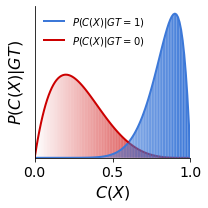

In [83]:
# this plot is generated by simulation parameters: pos_y_density and neg_y_density
# positive and negative density function
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

for bin_idx in range(num_bin):
    ax.fill_between([x_axis[bin_idx], x_axis[bin_idx+1]], [0, 0], 
                    [pos_y_density[bin_idx], pos_y_density[bin_idx+1]], 
                    facecolor=tp_color, alpha=(x_axis[bin_idx] + x_axis[bin_idx+1]) / 2, lw=0, zorder=40)

    ax.fill_between([x_axis[bin_idx], x_axis[bin_idx+1]], [0, 0], 
                    [neg_y_density[bin_idx], neg_y_density[bin_idx+1]], 
                    facecolor=fp_color, alpha=(x_axis[bin_idx] + x_axis[bin_idx+1]) / 2, lw=0)

ax.plot(x_axis, pos_y_density, c=tp_color, lw=2, label='$P(C(X)|GT=1)$')
ax.plot(x_axis, neg_y_density, c=fp_color, lw=2, label='$P(C(X)|GT=0)$')

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('$P(C(X)|GT)$', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(frameon=False)

plt.tight_layout()

In [84]:
def concise_fmt(x, pos):
#     if abs(x) // 1000000000 > 0:
#         return '{0:.0f}B'.format(x / 1000000000)
#     elif abs(x) // 100000000 > 0:
#         return '{0:.0f}B'.format(x / 1000000000)
#     elif abs(x) // 1000000 > 0:
#         return '{0:.0f}M'.format(x / 1000000)
#     elif abs(x) // 100000 > 0:
#         return '{0:.1f}M'.format(x / 1000000)
    if abs(x) // 1000 > 0:
        return '{0:.0f}K'.format(x / 1000)
    elif x == 10:
        return '10'
    elif x == 1:
        return '1'
    else:
        return '{0:.0f}'.format(x)

In [22]:
def get_bin_idx(score, size=20):
    return min(int(score * size), size-1)

In [23]:
# this plot is generated by simulation parameters: pos_gt_density and neg_gt_density
# positive and negative density function
def simulate_cx_given_gt(a_pos, b_pos, a_neg, b_neg, lam=1, 
                         p_p_list=[0.1], size_list=[10000], scenario_list=['normal day']):
    """
    This is a funcation that...
      
    Attributes:
        a_pos: alpha value of the Beta distribution for the GT positive items
        b_pos: beta value of the Beta distribution for the GT positive items
    """
    
    # configurations
    num_scenario = len(p_p_list)
    fig, axes = plt.subplots(1 + num_scenario, 5, figsize=(17, 3 + 3 * num_scenario))
    positive_color = '#3d85c6'
    negative_color = '#cc0000'
    num_theor_slice = 100
    theor_cx_axis = np.linspace(0, 1, num_theor_slice)
    num_empir_bin = 20
    empir_cx_axis = np.linspace(0, 1, num_empir_bin)

    # positive density function
    pos_rv = stats.beta(a_pos, b_pos)
    pos_gt_density = lam * pos_rv.pdf(theor_cx_axis) + (1 - lam) * stats.uniform.pdf(theor_cx_axis)

    # negative density function
    neg_rv = stats.beta(a_neg, b_neg)
    neg_gt_density = lam * neg_rv.pdf(theor_cx_axis) + (1 - lam) * stats.uniform.pdf(theor_cx_axis)

    # first row: plot the conditional density function
    axes[0, 0].fill_between(theor_cx_axis, np.zeros(num_theor_slice), 
                            pos_gt_density, 
                            facecolor=positive_color, alpha=0.5, lw=2, zorder=40,
                            label=f'$P(C(X)|GT=1)$\n$\sim Beta({a_pos}, {b_pos})$')

    axes[0, 0].fill_between(theor_cx_axis, np.zeros(num_theor_slice), 
                            neg_gt_density,
                            facecolor=negative_color, alpha=0.5, lw=2,
                            label=f'$P(C(X)|GT=0)$\n$\sim Beta({a_neg}, {b_neg})$')

    axes[0, 0].set_xlabel('$C(X)$', fontsize=16)
    axes[0, 0].set_ylabel('$P(C(X)|GT)$', fontsize=16)
    axes[0, 0].set_xlim([0, 1.02])
    axes[0, 0].set_ylim(ymin=0)
    axes[0, 0].set_yticks([])
    axes[0, 0].legend(frameon=False)

    for row_idx, (p_p, size, scenario) in enumerate(zip(p_p_list, size_list, scenario_list)):
        row_idx += 1

        p_n = 1 - p_p
        num_pos = int(size * p_p)
        num_neg = size - num_pos
        
        pos_draws = pos_rv.rvs(num_pos)
        pos_bin_idx_counter = Counter([get_bin_idx(cx, size=num_empir_bin) for cx in pos_draws])

        neg_draws = neg_rv.rvs(num_neg)
        neg_bin_idx_counter = Counter([get_bin_idx(cx, size=num_empir_bin) for cx in neg_draws])

        axes[row_idx, 0].bar(['$P(GT=0)$', '$P(GT=1)$'], [p_n, p_p], width=0.7, 
                             color=[negative_color, positive_color], lw=2, edgecolor='k')
        axes[row_idx, 0].set_xlabel(scenario, fontsize=16)
        axes[row_idx, 0].set_ylabel('$P(GT)$', fontsize=16)
        axes[row_idx, 0].set_ylim([0, 1])
        
        axes[row_idx, 1].hist(pos_draws, density=False, color=positive_color,
                              bins=num_empir_bin, histtype='stepfilled', alpha=0.5)
        
        axes[row_idx, 1].hist(neg_draws, density=False, color=negative_color,
                              bins=num_empir_bin, histtype='stepfilled', alpha=0.5)

        overall_pos_freq_list = []
        overall_neg_freq_list = []
        overall_freq_list = []

        for bin_idx in range(num_empir_bin):            
            if bin_idx in pos_bin_idx_counter:
                bin_pos_freq = pos_bin_idx_counter[bin_idx]
            else:
                bin_pos_freq = 0

            if bin_idx in neg_bin_idx_counter:
                bin_neg_freq = neg_bin_idx_counter[bin_idx]
            else:
                bin_neg_freq = 0
            
            bin_overall_freq = bin_pos_freq + bin_neg_freq
            
            overall_pos_freq_list.append(bin_pos_freq)
            overall_neg_freq_list.append(bin_neg_freq)
            overall_freq_list.append(bin_overall_freq)

        axes[row_idx, 2].bar(empir_cx_axis, overall_pos_freq_list, width=1 / num_empir_bin,
                             color=positive_color, alpha=0.5, lw=2)

        axes[row_idx, 2].bar(empir_cx_axis, overall_neg_freq_list, width=1 / num_empir_bin,
                             color=negative_color, alpha=0.5, lw=2, bottom=overall_pos_freq_list)
        axes[row_idx, 2].plot(empir_cx_axis, overall_pos_freq_list, c=positive_color, lw=2)
        axes[row_idx, 2].plot(empir_cx_axis, overall_freq_list, c=negative_color, lw=2)

        axes[row_idx, 3].bar(empir_cx_axis, overall_freq_list, width=1 / num_empir_bin,
                             color='k', alpha=0.5)
        axes[row_idx, 3].plot(empir_cx_axis, overall_freq_list, c='k', lw=2)

        axes[row_idx, 4].plot(empir_cx_axis, np.array(overall_pos_freq_list) / np.array(overall_freq_list),
                              c='k', lw=2, label='Non-parametric binning')
        
        train_X = np.concatenate((pos_draws, neg_draws)).reshape(-1, 1)
        train_y = np.concatenate((np.ones(num_pos), np.zeros(num_neg))).ravel()
        prob_cali_func = LogisticRegression(fit_intercept=True).fit(train_X, train_y)
        prob_cali_curve = prob_cali_func.predict_proba(empir_cx_axis.reshape(-1, 1))[:, -1]
        prob_cali_curve_w = prob_cali_func.coef_[0][0]
        prob_cali_curve_b = prob_cali_func.intercept_[0]

        axes[row_idx, 4].plot(empir_cx_axis, prob_cali_curve, 'k--', lw=2, 
                              label=f'Platt scaling \n w={prob_cali_curve_w:.3f} \n b={prob_cali_curve_b:.3f}')

        axes[row_idx, 4].set_ylabel('$P(GT=1|C(X))$', fontsize=16)
        axes[row_idx, 4].set_ylim([0, 1.02])
        axes[row_idx, 4].legend(frameon=False)

        for col_idx in [1, 2, 3, 4]:
            axes[row_idx, col_idx].set_xlabel('$C(X)$', fontsize=16)
            axes[row_idx, col_idx].set_xlim([0, 1.02])
            axes[row_idx, col_idx].set_xticks([0, 0.5, 1])
            axes[row_idx, col_idx].set_ylim(ymin=0)

        for col_idx in [1, 2, 3]:
            axes[row_idx, col_idx].set_ylabel('frequency', fontsize=16)
#             axes[row_idx, col_idx].yaxis.set_major_formatter(FuncFormatter(concise_fmt))


    for col_idx in [1, 2, 3, 4]:
        axes[0, col_idx].set_axis_off()

    for ax in axes.ravel():
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=14)

    plt.tight_layout()

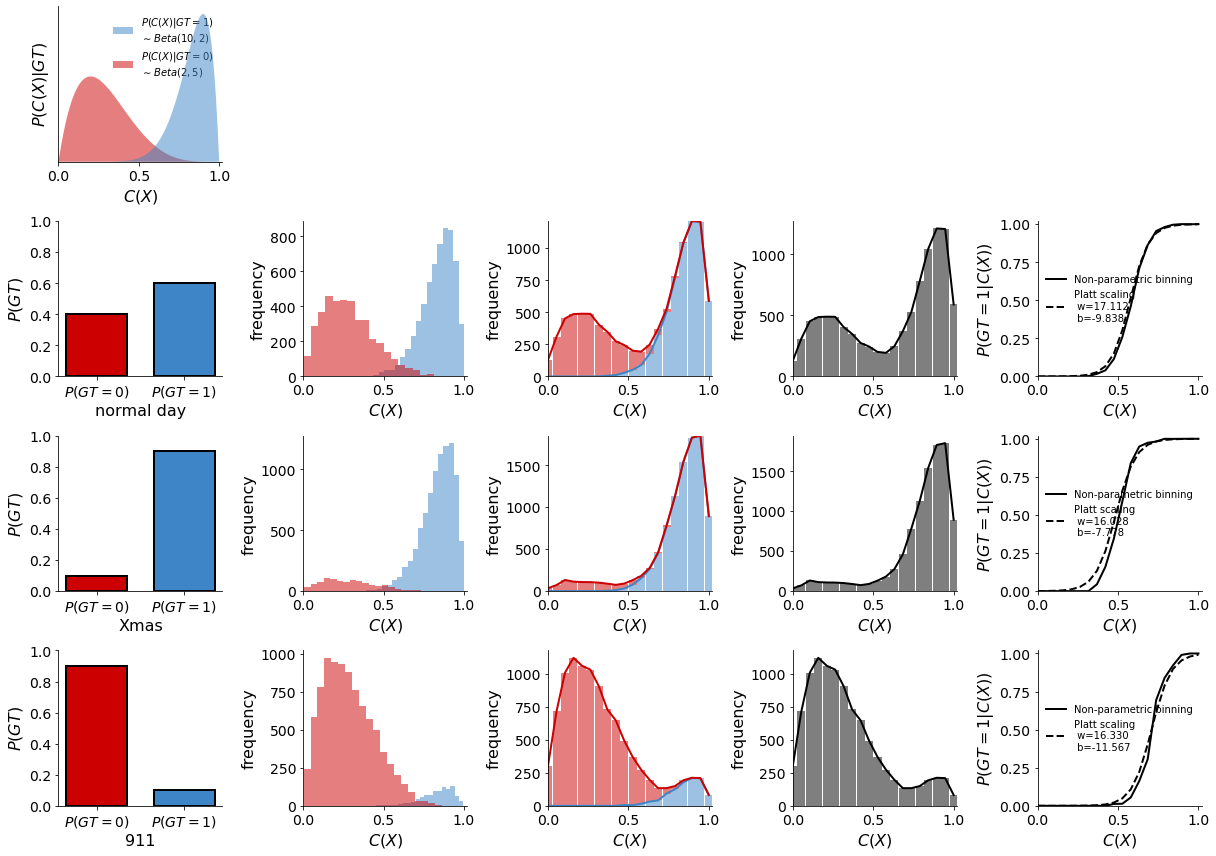

In [97]:
# y -> x data simulation configuration
simulate_cx_given_gt(a_pos=10, b_pos=2, a_neg=2, b_neg=5, 
                    p_p_list=[0.6, 0.9, 0.1], 
                    size_list=[10000, 10000, 10000], 
                    scenario_list=['normal day', 'Xmas', '911'])

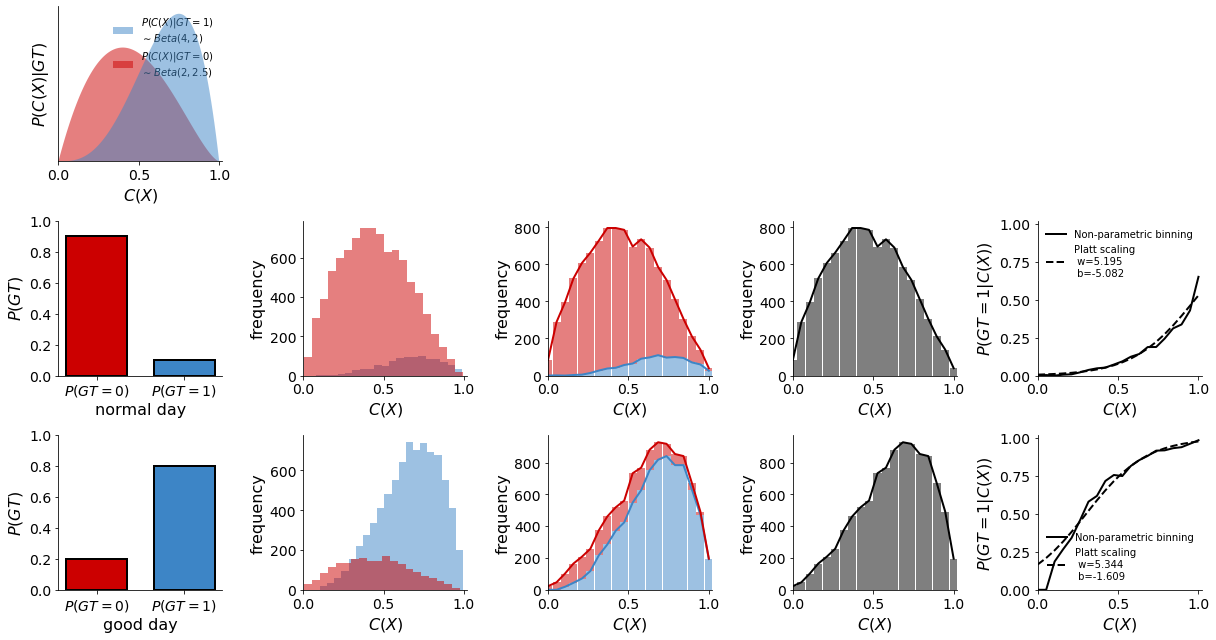

In [25]:
simulate_cx_given_gt(a_pos=4, b_pos=2, a_neg=2, b_neg=2.5, 
                    p_p_list=[0.1, 0.8], size_list=[10000, 10000], scenario_list=['normal day', 'good day'])

In [1]:
from typing import Sequence, Dict
from collections import defaultdict, Counter
import random
import math
import numpy as np
import pandas as pd
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from sklearn.linear_model import LogisticRegression

from abc import ABC, abstractmethod
from IPython import display
import krippendorff
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
########### States #############################
class State:
    @abstractmethod
    def __init__(self):
        pass

    @abstractmethod
    def draw_labels(self, n):
        pass

class DiscreteState(State):
    """
    A discrete distribution over possible labels

    Parameters
    ----------
    state_name
    labels
        A sequence of strings; the allowable labels
    probabilities
        A sequence of the same length, with values adding to one, giving probabilities for each of the label strings
    """

    def __init__(self,
                 state_name: str,
                 labels: Sequence[str],
                 probabilities: Sequence[float],
                 ):
        super().__init__()
        self.state_name = state_name
        self.labels = labels
        self.probabilities = np.array(probabilities)

    def __repr__(self):
        return f"DiscreteState {self.state_name}: {list(zip(self.labels, self.probabilities))}"

    def pr_list(self):
        return [(p, l) for p, l in zip(self.probabilities, self.labels)]

    def draw_labels(self, n: int):
        """
        Make n iid draws of discrete labels from the distribution

        Parameters
        ----------
        n
            How many labels to draw from the distribution

        Returns
        -------
            a single item or a numpy array
        """
        
        probabilities = probabilities / probabilities.sum()
        
        return np.random.choice(
            self.labels,
            n,
            p=probabilities
        )

In [3]:
############ Distributions over states ###############
class DistributionOverStates(ABC):
    """
    Abstract base class
    """
    @abstractmethod
    def __init__(self):
        pass

    @abstractmethod
    def draw_states(self, n: int):
        pass

    def generate_labels(self, num_items:int, num_labels_per_item=10, rater_prefix='r', reweight=1):
        return pd.DataFrame(
        [state.draw_labels(num_labels_per_item, reweight=reweight) for state in self.item_states],
        columns=[f"{rater_prefix}_{i}" for i in range(1, num_labels_per_item + 1)]
        )

class DiscreteDistributionOverStates(DistributionOverStates):
    """
    Parameters
    ----------
    states
        a sequence of State objects
    probabilities
        a same length sequence of floats representing probabilities of the item states
    """

    def __init__(self, states: Sequence[State], probabilities: Sequence[float]):
        super().__init__()
        self.probabilities = probabilities
        self.states = states

    def draw_states(self, n: int) -> Sequence[DiscreteState]:
        """

        Parameters
        ----------
        n

        Returns
        -------
            a single item or numpy array of State instances, drawn iid from the probability distribution
        """    

        return np.random.choice(
            self.states,
            size=n,
            p=self.probabilities
        )

class BetaDistribution(DistributionOverStates):
    def __init__(self, alpha, beta, name):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.name = name

    def draw_states(self, n=100, show_dist=False) -> Sequence[DiscreteState]:
        alpha, beta = self.alpha, self.beta
        data = np.random.beta(alpha, beta, n)
        if show_dist:
#             data_ma = np.ma.masked_array(data, mask=samples)
#             true_labels = data_ma[data_ma.mask]
#             false_labels = data_ma[~data_ma.mask]
#             plt.hist(true_labels, bins=10, density=True, histtype='step', label='true')
#             plt.hist(false_labels, bins=10, density=True, histtype='step', label='false')
            plt.hist(data, bins=20, density=True, histtype='step', label=self.name)
            plt.xlabel('classifier score')
            plt.ylabel('density')
            plt.legend()
            plt.show()
#         return DiscreteState(self.name, data)
        return data

class DiscreteDist(DistributionOverStates):
    def __init__(self, alpha, name):
        super().__init__()
        self.alpha = alpha
        self.name = name

    def draw_states(self, n=100, show_dist=False) -> Sequence[DiscreteState]:
        data = np.random.binomial(1, self.alpha, n)
        
        if show_dist:
            plt.hist(data, bins=2, density=False, histtype='step', label=self.name)
            plt.xlabel('classifier score')
            plt.ylabel('freq')
            plt.legend()
            plt.show()
        return data

In [4]:
def get_bin_idx(score, size=10):
    return min(int(score * size), size-1)

In [5]:
# Simulate datasets with varying prevalence
def simulate_dataset(p, lam, pos_pool, neg_pool, noise_pool, size=10000):
    num_pos = int(p * size)
    num_pos_beta = int(lam * p * size)
    num_pos_uni = int((1 - lam) * p * size)
    num_neg = size - num_pos
    num_neg_beta = int(lam * (1 - p) * size)
    num_neg_uni = int((1 - lam) * (1 - p) * size)
    
    selected_pos = np.concatenate((np.random.choice(pos_pool, size=num_pos_beta, replace=False),
                                   np.random.choice(noise_pool, size=num_pos_uni, replace=False)))
    selected_neg = np.concatenate((np.random.choice(neg_pool, size=num_neg_beta, replace=False),
                                   np.random.choice(noise_pool, size=num_neg_uni, replace=False)))
    
#     print(selected_neg[:10])
    
    pred_list = []
    true_list = []
    
    bin_pos = [0] * 10
    bin_neg = [0] * 10

    for pred_label in selected_pos:
        pred_list.append(pred_label)
        true_list.append(True)
        bin_idx = get_bin_idx(pred_label)
        bin_pos[bin_idx] += 1        
        
    for pred_label in selected_neg:
        pred_list.append(pred_label)
        true_list.append(False)
        bin_idx = get_bin_idx(pred_label)
        bin_neg[bin_idx] += 1

#     fig, axes = plt.subplots(1, 3, figsize=(14, 3))
#     axes[0].hist(pred_list, bins=20, density=True, histtype='step', label='all data')
#     axes[1].hist(selected_pos, bins=20, density=True, histtype='step', label='positive density function')
#     axes[1].hist(selected_neg, bins=20, density=True, histtype='step', label='negative density function')
#     axes[0].legend()
#     axes[1].legend()
    
#     axes[2].scatter(range(10), [x/(x+y) for x, y in zip(bin_pos, bin_neg)], label='calibration curve')
#     axes[2].legend()    
    
    threshold = 0.5
    tpr = len([x for x in selected_pos if x >= threshold])/ len(selected_pos)
    fpr = len([x for x in selected_neg if x >= threshold])/ len(selected_neg)
    print(tpr, fpr)
#     x_axis = ['$f(X)=0$', '$f(X)=1$']
#     y_axis = lambda y: [(len(y) - sum(y))/len(y), sum(y)/len(y)]
#     axes[0].bar(x_axis, y_axis(selected_pos))
#     axes[0].set_ylabel('$P(f(X)|y=1)$')
#     axes[1].bar(x_axis, y_axis(selected_neg))
#     axes[1].set_ylabel('$P(f(X)|y=0)$')
#     axes[2].bar(x_axis, y_axis(pred_list))
#     axes[2].set_ylabel('$P(f(X))$')

    print(f'prevalence: {p * 100:.2f}%, lambda: {lam * 100:.2f}%, num_pos: {num_pos}, num_neg: {num_neg}')
    return pred_list, true_list

In [100]:
_SQRT2 = np.sqrt(2)

def hellinger(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

In [16]:
light_gray_color = '#efefef'
dark_gray_color = '#666666'

positive_color = '#3d85c6'
negative_color = '#cc0000'

blue_color = '#c9daf8'
red_color = '#f4cccc'

tp_color = '#3c78d8'
fn_color = '#c9daf8'
fp_color = '#cc0000'
tn_color = '#f4cccc'

pos_a = 3
pos_b = 1
neg_a = 1
neg_b = 4

In [17]:
lam = 0.7
p_p = 0.1
p_n = 1 - p_p
bin_size = 0.01
num_bin = int(1/bin_size)

In [9]:
def generate_item_pool(alpha, beta, name, show_dist=True):
    items = BetaDistribution(alpha, beta, name)
    pool = items.draw_states(n=1000000, show_dist=show_dist)
    return pool

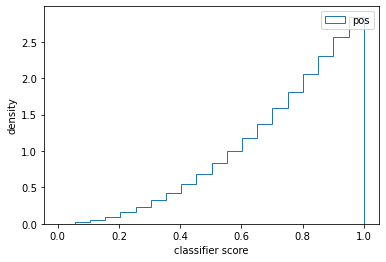

In [10]:
pos_pool = generate_item_pool(pos_a, pos_b, 'pos')

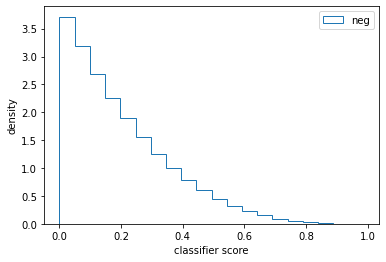

In [11]:
neg_pool = generate_item_pool(neg_a, neg_b, 'neg')

In [12]:
noise_pool = np.random.uniform(low=0, high=1, size=1000000)

In [13]:
base_scores, base_labels = simulate_dataset(p=p_p, lam=lam, pos_pool=pos_pool, neg_pool=neg_pool, noise_pool=noise_pool, size=100000)

0.7647764776477648 0.1927888888888889
prevalence: 10.00%, lambda: 70.00%, num_pos: 10000, num_neg: 90000


In [19]:
# configuration
pos_a = 10
pos_b = 2
neg_a = 2
neg_b = 5
lam = 1

num_bin = 100
x_axis = np.linspace(0, 1, num_bin + 1)

# simulate the data
# positive density function
pos_y_density = lam * stats.beta.pdf(x_axis, pos_a, pos_b) + (1 - lam) * stats.uniform.pdf(x_axis)

# negative density function
neg_y_density = lam * stats.beta.pdf(x_axis, neg_a, neg_b) + (1 - lam) * stats.uniform.pdf(x_axis)

p_p = 0.2
p_n = 1 - p_p

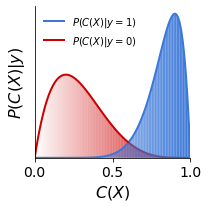

In [15]:
# this plot is generated by simulation parameters: pos_y_density and neg_y_density
# positive and negative density function
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

for bin_idx in range(num_bin):
    ax.fill_between([x_axis[bin_idx], x_axis[bin_idx+1]], [0, 0], 
                    [pos_y_density[bin_idx], pos_y_density[bin_idx+1]], 
                    facecolor=tp_color, alpha=(x_axis[bin_idx] + x_axis[bin_idx+1]) / 2, lw=0, zorder=40)

    ax.fill_between([x_axis[bin_idx], x_axis[bin_idx+1]], [0, 0], 
                    [neg_y_density[bin_idx], neg_y_density[bin_idx+1]], 
                    facecolor=fp_color, alpha=(x_axis[bin_idx] + x_axis[bin_idx+1]) / 2, lw=0)

ax.plot(x_axis, pos_y_density, c=tp_color, lw=2, label='$P(C(X)|y=1)$')
ax.plot(x_axis, neg_y_density, c=fp_color, lw=2, label='$P(C(X)|y=0)$')

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('$P(C(X)|y)$', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(frameon=False)

plt.tight_layout()

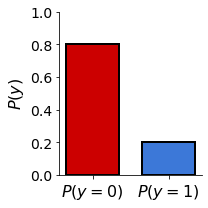

In [16]:
# this plot is generated by simulation parameters: p_p
# fraction of grouth truth positives

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

ax.bar(['$P(y=0)$', '$P(y=1)$'], [p_n, p_p], width=0.7, color=[fp_color, tp_color], lw=2, edgecolor='k')

ax.set_ylabel('$P(y)$', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim([0, 1])
ax.tick_params(axis='y', which='major', labelsize=14)
ax.tick_params(axis='x', which='major', labelsize=16)

plt.tight_layout()

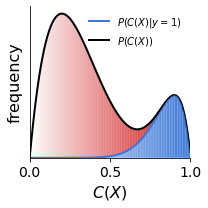

In [17]:
# this plot is generated by inference
# joint distribution
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

overall_density_list = p_p * pos_y_density + p_n * neg_y_density
overall_positive_list = p_p * pos_y_density

for bin_idx in range(num_bin):
    point_overall_y_density_1 = p_p * pos_y_density[bin_idx] + p_n * neg_y_density[bin_idx]
    point_overall_y_density_2 = p_p * pos_y_density[bin_idx+1] + p_n * neg_y_density[bin_idx+1]
    
    point_pos_y_density_1 = p_p * pos_y_density[bin_idx]
    point_pos_y_density_2 = p_p * pos_y_density[bin_idx+1]
    
    ax.fill_between([x_axis[bin_idx], x_axis[bin_idx+1]], [0, 0], 
                    [point_pos_y_density_1, point_pos_y_density_2], 
                    facecolor=tp_color, alpha=(x_axis[bin_idx] + x_axis[bin_idx+1]) / 2, lw=0, zorder=40)

    ax.fill_between([x_axis[bin_idx], x_axis[bin_idx+1]], [point_pos_y_density_1, point_pos_y_density_2], 
                    [point_overall_y_density_1, point_overall_y_density_2], 
                    facecolor=fp_color, alpha=(x_axis[bin_idx] + x_axis[bin_idx+1]) / 2, lw=0)

ax.plot(x_axis, overall_positive_list, c=tp_color, lw=2, label='$P(C(X)|y=1)$')
ax.plot(x_axis, overall_density_list, c='k', lw=2, label='$P(C(X))$')

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(frameon=False)

plt.tight_layout()

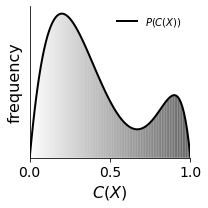

In [18]:
# this plot is generated by inference
# observed frequency
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

overall_density_list = p_p * pos_y_density + p_n * neg_y_density

for bin_idx in range(num_bin):
    point_overall_y_density_1 = p_p * pos_y_density[bin_idx] + p_n * neg_y_density[bin_idx]
    point_overall_y_density_2 = p_p * pos_y_density[bin_idx+1] + p_n * neg_y_density[bin_idx+1]

    ax.fill_between([x_axis[bin_idx], x_axis[bin_idx+1]], [0, 0], 
                    [point_overall_y_density_1, point_overall_y_density_2], 
                    facecolor=dark_gray_color, alpha=(x_axis[bin_idx] + x_axis[bin_idx+1]) / 2, lw=0)

ax.plot(x_axis, overall_density_list, c='k', lw=2, label='$P(C(X))$')

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(frameon=False)

plt.tight_layout()

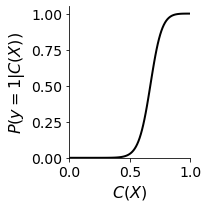

In [19]:
# this plot is generated by inference
# calibration curve
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

overall_density_list = p_p * pos_y_density + p_n * neg_y_density
overall_positive_list = p_p * pos_y_density

ax.plot(x_axis[1: -1], overall_positive_list[1: -1] / overall_density_list[1: -1], c='k', lw=2)

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('$P(y=1|C(X))$', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()

# Put all figures together

## Inference process

In [98]:
# this plot is generated by simulation parameters: pos_gt_density and neg_gt_density
def inference_cx_given_gt(a_pos, b_pos, a_neg, b_neg, lam=1, 
                          p_p_list=[0.1], size_list=[10000], scenario_list=['normal day']):
    """
    This is a funcation that...
      
    Attributes:
        a_pos: alpha value of the Beta distribution for the GT positive items
        b_pos: beta value of the Beta distribution for the GT positive items
    """
    
    # configurations
    num_scenario = len(p_p_list)
    fig, axes = plt.subplots(1 + num_scenario, 5, figsize=(17, 3 + 3 * num_scenario))
    positive_color = '#3d85c6'
    negative_color = '#cc0000'
    num_theor_slice = 100
    theor_cx_axis = np.linspace(0, 1, num_theor_slice)
    num_empir_bin = 20
    empir_cx_axis = np.linspace(0, 1, num_empir_bin)

    # positive density function
    pos_rv = stats.beta(a_pos, b_pos)
    pos_gt_density = lam * pos_rv.pdf(theor_cx_axis) + (1 - lam) * stats.uniform.pdf(theor_cx_axis)

    # negative density function
    neg_rv = stats.beta(a_neg, b_neg)
    neg_gt_density = lam * neg_rv.pdf(theor_cx_axis) + (1 - lam) * stats.uniform.pdf(theor_cx_axis)

    # first row: plot the conditional density function
    axes[0, 0].fill_between(theor_cx_axis, np.zeros(num_theor_slice), 
                            pos_gt_density, 
                            facecolor=positive_color, alpha=0.5, lw=2, zorder=40,
                            label=f'$P(C(X)|GT=1)$\n$\sim Beta({a_pos}, {b_pos})$')

    axes[0, 0].fill_between(theor_cx_axis, np.zeros(num_theor_slice), 
                            neg_gt_density,
                            facecolor=negative_color, alpha=0.5, lw=2,
                            label=f'$P(C(X)|GT=0)$\n$\sim Beta({a_neg}, {b_neg})$')

    axes[0, 0].set_xlabel('$C(X)$', fontsize=16)
    axes[0, 0].set_ylabel('$P(C(X)|GT)$', fontsize=16)
    axes[0, 0].set_xlim([0, 1.02])
    axes[0, 0].set_ylim(ymin=0)
    axes[0, 0].set_yticks([])
    axes[0, 0].legend(frameon=False)

    for row_idx, (p_p, size, scenario) in enumerate(zip(p_p_list, size_list, scenario_list)):
        row_idx += 1

        p_n = 1 - p_p
        num_pos = int(size * p_p)
        num_neg = size - num_pos
        
        pos_draws = pos_rv.rvs(num_pos)
        pos_bin_idx_counter = Counter([get_bin_idx(cx, size=num_empir_bin) for cx in pos_draws])

        neg_draws = neg_rv.rvs(num_neg)
        neg_bin_idx_counter = Counter([get_bin_idx(cx, size=num_empir_bin) for cx in neg_draws])

        axes[row_idx, 0].bar(['$P(GT=0)$', '$P(GT=1)$'], [p_n, p_p], width=0.7, 
                             color=[negative_color, positive_color], lw=2, edgecolor='k')
        axes[row_idx, 0].set_xlabel(scenario, fontsize=16)
        axes[row_idx, 0].set_ylabel('$P(GT)$', fontsize=16)
        axes[row_idx, 0].set_ylim([0, 1])

        overall_pos_freq_list = []
        overall_neg_freq_list = []
        overall_freq_list = []
        
        for bin_idx in range(num_empir_bin):            
            if bin_idx in pos_bin_idx_counter:
                bin_pos_freq = pos_bin_idx_counter[bin_idx]
            else:
                bin_pos_freq = 0

            if bin_idx in neg_bin_idx_counter:
                bin_neg_freq = neg_bin_idx_counter[bin_idx]
            else:
                bin_neg_freq = 0
            
            bin_overall_freq = bin_pos_freq + bin_neg_freq
            
            overall_pos_freq_list.append(bin_pos_freq)
            overall_neg_freq_list.append(bin_neg_freq)
            overall_freq_list.append(bin_overall_freq)

        axes[row_idx, 1].plot(empir_cx_axis, overall_freq_list, c='k', lw=2)
                
        # sample some data for human annotation
        bin_data_tuple_list = [[] for _ in range(num_empir_bin)]
        for pos_cx in pos_draws:
            bin_idx = get_bin_idx(pos_cx, size=num_empir_bin)
            bin_data_tuple_list[bin_idx].append((pos_cx, 1))
        for neg_cx in neg_draws:
            bin_idx = get_bin_idx(neg_cx, size=num_empir_bin)
            bin_data_tuple_list[bin_idx].append((neg_cx, 0))
        
        # build training data
        min_sample = 1000
        calibration_sample_list = [random.sample(bin_data_tuple, min((min_sample, len(bin_data_tuple)))) for bin_data_tuple in bin_data_tuple_list]
        axes[row_idx, 1].bar(empir_cx_axis, [len(bin_data_tuple) for bin_data_tuple in calibration_sample_list], width=1 / num_empir_bin, 
                             color='k', alpha=0.5)
        
        non_parametric_list = [sum([gt for _, gt in bin_data_tuple]) / len(bin_data_tuple) for bin_data_tuple in calibration_sample_list]
#         axes[row_idx, 2].plot(empir_cx_axis, np.array(overall_pos_freq_list) / np.array(overall_freq_list),
        axes[row_idx, 2].plot(empir_cx_axis, non_parametric_list,
                              c='k', lw=2, label='Non-parametric binning')
        
        train_X = []
        train_y = []
        for bin_data_tuple in calibration_sample_list:
            for cx, gt in bin_data_tuple:
                train_X.append(cx)
                train_y.append(gt)
        
        train_X = np.array(train_X).reshape(-1, 1)
        train_y = np.array(train_y)
        prob_cali_func = LogisticRegression(fit_intercept=True).fit(train_X, train_y)
        prob_cali_curve = prob_cali_func.predict_proba(empir_cx_axis.reshape(-1, 1))[:, -1]
        prob_cali_curve_w = prob_cali_func.coef_[0][0]
        prob_cali_curve_b = prob_cali_func.intercept_[0]

        axes[row_idx, 2].plot(empir_cx_axis, prob_cali_curve, 'k--', lw=2, 
                              label=f'Platt scaling \n w={prob_cali_curve_w:.3f} \n b={prob_cali_curve_b:.3f}')

        axes[row_idx, 2].set_ylabel('$P(GT=1|C(X))$', fontsize=16)
        axes[row_idx, 2].set_ylim([0, 1.02])
        axes[row_idx, 2].legend(frameon=False)
        
        # positive and negative density function
        sample_pos_draws = []
        sample_neg_draws = []
        for bin_data_tuple in calibration_sample_list:
            for cx, gt in bin_data_tuple:
                if gt:
                    sample_pos_draws.append(cx)
                else:
                    sample_neg_draws.append(cx)
                    
        pos_y, pos_bins, _ = axes[row_idx, 3].hist(sample_pos_draws, density=True, color=positive_color,
                              bins=np.linspace(0, 1, num_empir_bin+1), histtype='stepfilled', alpha=0.5)
        
        neg_y, neg_bins, _ = axes[row_idx, 3].hist(sample_neg_draws, density=True, color=negative_color,
                              bins=np.linspace(0, 1, num_empir_bin+1), histtype='stepfilled', alpha=0.5)
        
        axes[row_idx, 3].plot(pos_bins[1:], pos_y, color=positive_color)
        axes[row_idx, 3].plot(neg_bins[1:], neg_y, color=negative_color)
        
        # inference with two methods: PE and Mixed mixture
        all_data = [item for sublist in bin_data_tuple_list for item in sublist]
        obs_cx_array = np.array([x for x, _ in all_data]).reshape(-1, 1)
        pe_method_result = sum(prob_cali_func.predict_proba(obs_cx_array)[:, -1]) / len(obs_cx_array)
        print(f'PE estimation: {pe_method_result:.3f}')
        
        # inference with mixed mixture, line search
        mm_prevalence = 0
        minimal_dist = 1
        pos_y = pos_y / sum(pos_y)
        neg_y = neg_y / sum(neg_y)
        
        for prevalence in np.arange(0.01, 1, 0.01):
            est_total = prevalence * pos_y + (1-prevalence) * neg_y
            est_total_array = np.array(est_total)
            obs_array = np.array(overall_freq_list)
            est_total_array /= sum(est_total_array)
            obs_array = obs_array / sum(obs_array)
            dist = hellinger(est_total_array, obs_array)
            if dist < minimal_dist:
                minimal_dist = dist
                mm_prevalence = prevalence
        print('mixed mixture estimation', mm_prevalence)
        
        axes[row_idx, 4].bar(['$GT_{PE}=0$', '$GT_{PE}=1$', '$GT_{MM}=0$', '$GT_{MM}=1$'], 
                             [1 - pe_method_result, pe_method_result, 1-mm_prevalence, mm_prevalence], width=0.7, 
                             color=[negative_color, positive_color, negative_color, positive_color], lw=2, edgecolor='k')
        axes[row_idx, 4].set_xlabel('PE and MM', fontsize=16)
        axes[row_idx, 4].set_ylabel('$P(GT)$', fontsize=16)
        axes[row_idx, 4].set_ylim([0, 1])
        
        
        for col_idx in [1, 2, 3]:
            axes[row_idx, col_idx].set_xlabel('$C(X)$', fontsize=16)
            axes[row_idx, col_idx].set_xlim([0, 1.02])
            axes[row_idx, col_idx].set_xticks([0, 0.5, 1])
            axes[row_idx, col_idx].set_ylim(ymin=0)
        axes[row_idx, 1].set_ylabel('frequency', fontsize=16)
        axes[row_idx, 2].set_ylabel('$P(GT=1|C(X))$', fontsize=16)
        axes[row_idx, 3].set_ylabel('density', fontsize=16)
#             axes[row_idx, col_idx].yaxis.set_major_formatter(FuncFormatter(concise_fmt))


    for col_idx in [1, 2, 3, 4]:
        axes[0, col_idx].set_axis_off()

    for ax in axes.ravel():
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=14)

    plt.tight_layout()

PE estimation: 0.600
mixed mixture estimation 0.6
PE estimation: 0.900
mixed mixture estimation 0.9
PE estimation: 0.100
mixed mixture estimation 0.09999999999999999


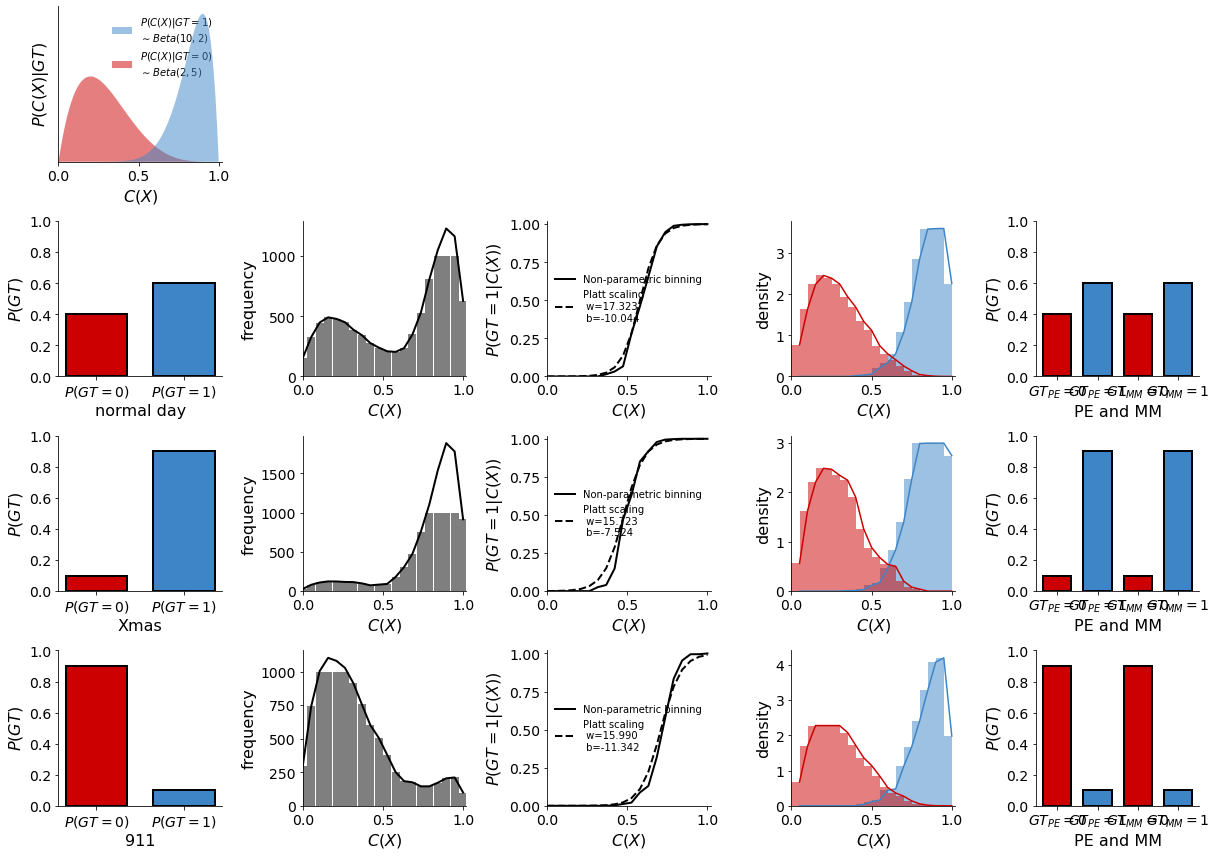

In [101]:
# y -> x data inference configuration
inference_cx_given_gt(a_pos=10, b_pos=2, a_neg=2, b_neg=5, 
                    p_p_list=[0.6, 0.9, 0.1], 
                    size_list=[10000, 10000, 10000], 
                    scenario_list=['normal day', 'Xmas', '911'])

# If the data generating process is $\mathcal{X} \rightarrow \mathcal{Y}$

Data generating process:
- For an item with a classifier score $C(X)$, we assume that the probability calibration curve $P(GT|C(X))$ is a Logistic regression function $LG(w, b) = \frac{1}{1 + e^{-(w + bX)}}$ (Platt scaling).

Random variable that we control (we allow it to change):
- Observed classifier score distribution, $P(C(X))$

Statistics that we can generate from the above parameters:
- Joint distribution between $C(X)$ and $GT$, $JD(C(X), GT)$
- Positive and negative density functions, $P(C(X)|GT=1)$ and $P(C(X)|GT=0)$
- Prevalence of GT positive items, $p_p$, or $P(GT=1)$

## Explaining with the house price prediction task

Task: Estimating the fraction of houses worth over $1M in an area

Data generating process:
- The classifier takes a few features as input, for example, Location, size, year built, design, layout, #bedrooms, etc. The learned classifier is a Logistic regression function $LG(w, b) = \frac{1}{1 + e^{-(w + bX)}}$ where $w=17.5, b=-10$

Random variable that we control (we allow it to change):
- Observed classifier score distribution, $P(C(X))$, can be any shapes

Statistics that we can generate from the above parameters:
- Joint distribution between $C(X)$ and $GT$, $JD(C(X), GT)$
- Positive and negative density functions, $P(C(X)|GT=1)$ and $P(C(X)|GT=0)$
- Prevalence of GT positive items, $p_p$, or $P(GT=1)$

In [103]:
# this plot is generated by simulation parameters: probability calibration curve
# positive and negative density function
def simulate_gt_given_cx(w, b, 
                         cx_list, size_list=[10000], scenario_list=['normal day']):
    """
    This is a class for mathematical operations on complex numbers.
      
    Attributes:
        real (int): The real part of complex number.
        imag (int): The imaginary part of complex number.
    """
    
    def _sigmoid(z):
        return 1 / (1 + math.exp(-z))
    
    def _prob_cali_func(x):
        return _sigmoid(w * x + b)
    
    # configurations
    num_scenario = len(cx_list)
    fig, axes = plt.subplots(1 + num_scenario, 5, figsize=(17, 3 + 3 * num_scenario))
    positive_color = '#3d85c6'
    negative_color = '#cc0000'
    num_theor_slice = 100
    theor_x_axis = np.linspace(0, 1, num_theor_slice)
    num_empir_bin = 20
    empir_x_axis = np.linspace(0, 1, num_empir_bin)

    # probability calibration function
    prob_cali_curve = [_prob_cali_func(x) for x in theor_x_axis]

    # first row: plot the conditional density function
    axes[0, 0].plot(theor_x_axis, prob_cali_curve, 'k--', lw=2, zorder=40,
                    label=f'$P(GT=1|C(X))$\n$\sim LG({w:.2f}, {b:.2f})$')

    axes[0, 0].set_xlabel('$C(X)$', fontsize=16)
    axes[0, 0].set_ylabel('$P(GT=1|C(X))$', fontsize=16)
    axes[0, 0].set_xlim([0, 1.02])
    axes[0, 0].set_ylim([0, 1.02])
    axes[0, 0].set_ylim(ymin=0)
    axes[0, 0].legend(frameon=False)

    for row_idx, (cxs, scenario) in enumerate(zip(cx_list, scenario_list)):
        row_idx += 1
        
        axes[row_idx, 0].hist(cxs, density=False, color='k',
                              bins=num_empir_bin, histtype='stepfilled', alpha=0.5)
        axes[row_idx, 0].set_xlabel(scenario, fontsize=16)

        calibrated_probability_list = [_prob_cali_func(cx) for cx in cxs]

        overall_pos_freq_list = [0] * num_empir_bin
        overall_neg_freq_list = [0] * num_empir_bin
        overall_freq_list = [0] * num_empir_bin
        
        gts = [random.choices([0, 1], [1-cali_prob, cali_prob])[0] for cali_prob in calibrated_probability_list]

        pos_draws = []
        neg_draws = []
        for cx, cali_prob, gt in zip(cxs, calibrated_probability_list, gts):
            bin_idx = get_bin_idx(cx, size=num_empir_bin)
            overall_freq_list[bin_idx] += 1
            overall_pos_freq_list[bin_idx] += cali_prob
            overall_neg_freq_list[bin_idx] += (1 - cali_prob)
            if gt == 1:
                pos_draws.append(cx)
            else:
                neg_draws.append(cx)

        axes[row_idx, 2].bar(empir_x_axis, overall_pos_freq_list, width=1 / num_empir_bin,
                             color=positive_color, alpha=0.5, lw=2)

        axes[row_idx, 2].bar(empir_x_axis, overall_neg_freq_list, width=1 / num_empir_bin,
                             color=negative_color, alpha=0.5, lw=2, bottom=overall_pos_freq_list)
        axes[row_idx, 2].plot(empir_x_axis, overall_pos_freq_list, c=positive_color, lw=2)
        axes[row_idx, 2].plot(empir_x_axis, overall_freq_list, c=negative_color, lw=2)
        
        axes[row_idx, 3].hist(pos_draws, density=False, color=positive_color,
                              bins=num_empir_bin, histtype='stepfilled', alpha=0.5)
        axes[row_idx, 3].hist(neg_draws, density=False, color=negative_color,
                              bins=num_empir_bin, histtype='stepfilled', alpha=0.5)
        
        p_p = len(pos_draws) / len(cxs)
        p_n = 1 - p_p

        axes[row_idx, 4].bar(['$P(GT=0)$', '$P(GT=1)$'], [p_n, p_p], width=0.7, 
                             color=[negative_color, positive_color], lw=2, edgecolor='k')
        axes[row_idx, 4].set_ylabel('$P(GT)$', fontsize=16)
        axes[row_idx, 4].set_ylim([0, 1])


    for col_idx in [1, 2, 3, 4]:
        axes[0, col_idx].set_axis_off()

    for ax in axes.ravel():
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=14)

    plt.tight_layout()

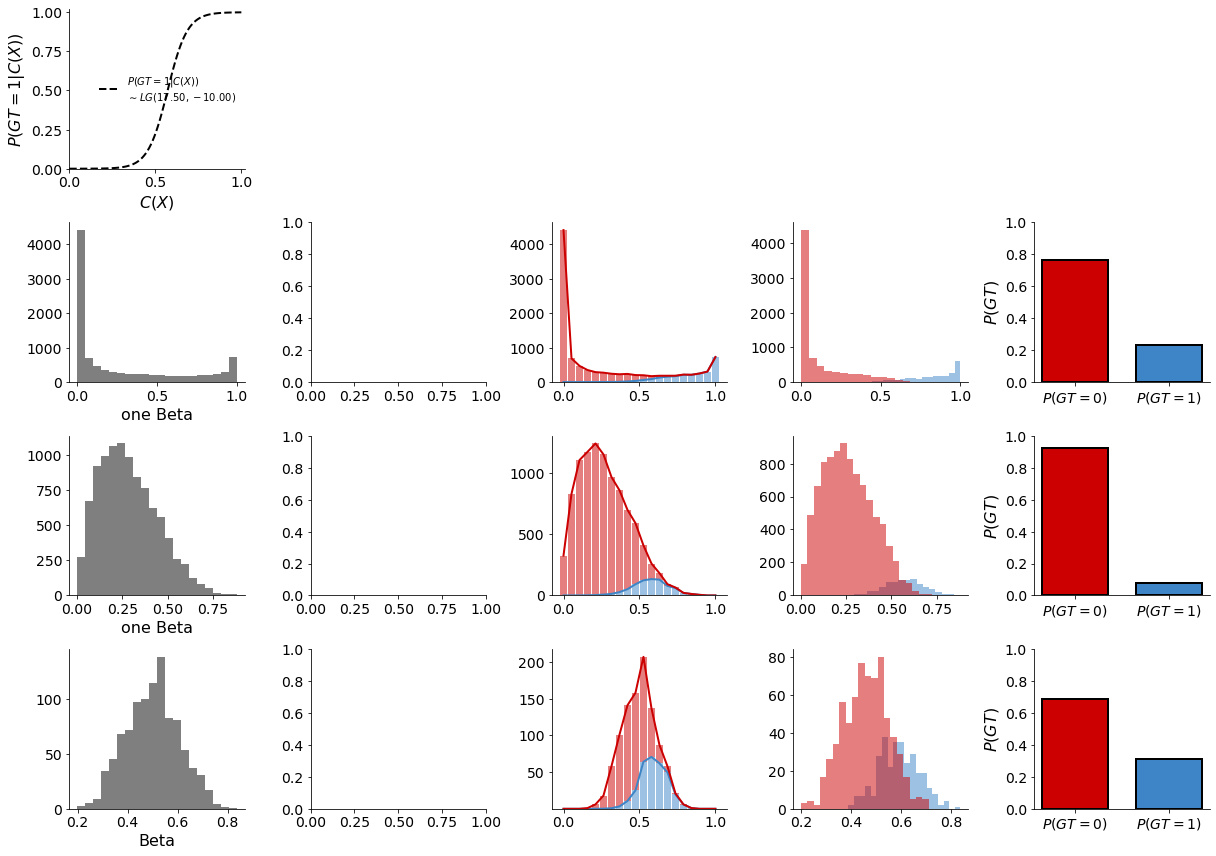

In [104]:
simulate_gt_given_cx(w=17.5, b=-10, 
                     cx_list=[stats.beta(0.2, 0.5).rvs(10000), stats.beta(2, 5).rvs(10000), stats.beta(10, 10).rvs(1000)], 
                     scenario_list=['one Beta', 'one Beta', 'Beta'])

# Sensivity analysis

# 

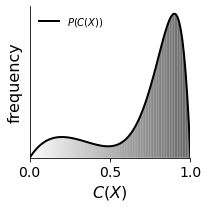

In [121]:
# this plot is generated by inference
# observed frequency
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

overall_density_list = p_p * pos_y_density + p_n * neg_y_density

for bin_idx in range(num_bin):
    point_overall_y_density_1 = p_p * pos_y_density[bin_idx] + p_n * neg_y_density[bin_idx]
    point_overall_y_density_2 = p_p * pos_y_density[bin_idx+1] + p_n * neg_y_density[bin_idx+1]

    ax.fill_between([x_axis[bin_idx], x_axis[bin_idx+1]], [0, 0], 
                    [point_overall_y_density_1, point_overall_y_density_2], 
                    facecolor=dark_gray_color, alpha=(x_axis[bin_idx] + x_axis[bin_idx+1]) / 2, lw=0)

ax.plot(x_axis, overall_density_list, c='k', lw=2, label='$P(C(X))$')

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(frameon=False)

plt.tight_layout()

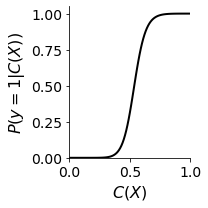

In [120]:
# this plot is generated by inference
# calibration curve
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

overall_density_list = p_p * pos_y_density + p_n * neg_y_density
overall_positive_list = p_p * pos_y_density

ax.plot(x_axis[1: -1], overall_positive_list[1: -1] / overall_density_list[1: -1], c='k', lw=2)

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('$P(y=1|C(X))$', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()

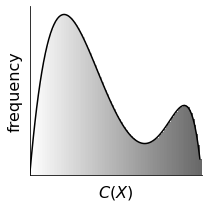

In [16]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

# simulate the data
x_axis = np.arange (0, 1, bin_size)

# positive density function
pos_y_density = lam * stats.beta.pdf(x_axis, pos_a, pos_b) + (1 - lam) * stats.uniform.pdf(x_axis)

# negative density function
neg_y_density = lam * stats.beta.pdf(x_axis, neg_a, neg_b) + (1 - lam) * stats.uniform.pdf(x_axis)

overall_y_density = []

for transpancy, x, pos_y, neg_y in zip(range(num_bin), x_axis, pos_y_density, neg_y_density):
    point_overall_y_density = p_p * pos_y + p_n * neg_y
    overall_y_density.append(point_overall_y_density)
    
    ax.fill_between([x, x+bin_size], [0, 0], 
                    [point_overall_y_density], 
                    facecolor=dark_gray_color, alpha=transpancy/num_bin, lw=0)

ax.plot(x_axis, overall_y_density, 'k')

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
# plt.savefig('fig3a.png', dpi=1000)

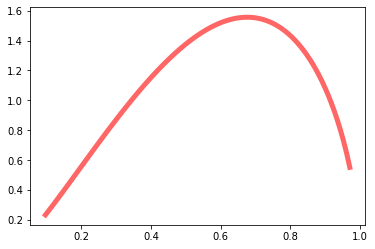

In [29]:
fig, ax = plt.subplots(1, 1)
a, b = 2.31, 1.627
x = np.linspace(stats.beta.ppf(0.01, a, b),
                stats.beta.ppf(0.99, a, b), 100)

ax.plot(x, stats.beta.pdf(x, a, b),
       'r-', lw=5, alpha=0.6, label='beta pdf')

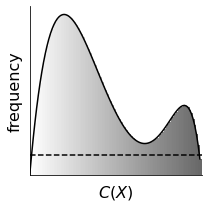

In [32]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

# simulate the data
x_axis = np.arange (0, 1, bin_size)

# positive density function
pos_y_density = lam * stats.beta.pdf(x_axis, pos_a, pos_b) + (1 - lam) * stats.uniform.pdf(x_axis)

# negative density function
neg_y_density = lam * stats.beta.pdf(x_axis, neg_a, neg_b) + (1 - lam) * stats.uniform.pdf(x_axis)

overall_y_density = []

for transpancy, x, pos_y, neg_y in zip(range(num_bin), x_axis, pos_y_density, neg_y_density):
    point_overall_y_density = p_p * pos_y + p_n * neg_y
    overall_y_density.append(point_overall_y_density)
    
    ax.fill_between([x, x+bin_size], [0, 0], 
                    [point_overall_y_density], 
                    facecolor=dark_gray_color, alpha=transpancy/num_bin, lw=0)

ax.plot(x_axis, overall_y_density, 'k')
ax.axhline(y=0.25, c='k', ls='--')

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
# plt.savefig('fig3b.png', dpi=1000)

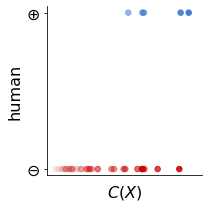

In [33]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

size_base = len(base_scores)

np.random.seed(47)
sampled_idx = np.random.choice(range(size_base), 50)

pos_scores = [base_scores[x] for x in sampled_idx if base_labels[x]]
pos_labels = [base_labels[x] for x in sampled_idx if base_labels[x]]
neg_scores = [base_scores[x] for x in sampled_idx if not base_labels[x]]
neg_labels = [base_labels[x] for x in sampled_idx if not base_labels[x]]

ax.scatter(pos_scores, pos_labels, s=30, color=tp_color, alpha=pos_scores)
ax.scatter(neg_scores, neg_labels, s=30, color=fp_color, alpha=neg_scores)

x_axis = np.arange(0, 1, bin_size)

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('human', fontsize=16)
ax.set_xlim([-0.04, 1.04])
ax.set_ylim([-0.04, 1.04])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([0, 1])
ax.set_yticklabels(['$\ominus$', '$\oplus$'])
ax.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
# plt.savefig('fig3c.png', dpi=1000)

/Users/siqiwu/Developments/env/anaconda3/envs/hot/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


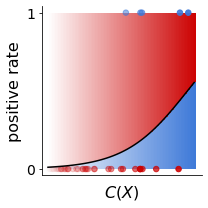

In [34]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

size_base = len(base_scores)

np.random.seed(47)
sampled_idx = np.random.choice(range(size_base), 50)

pos_scores = [base_scores[x] for x in sampled_idx if base_labels[x]]
pos_labels = [base_labels[x] for x in sampled_idx if base_labels[x]]
neg_scores = [base_scores[x] for x in sampled_idx if not base_labels[x]]
neg_labels = [base_labels[x] for x in sampled_idx if not base_labels[x]]

ax.scatter(pos_scores, pos_labels, s=30, color=tp_color, alpha=pos_scores, zorder=40)
ax.scatter(neg_scores, neg_labels, s=30, color=fp_color, alpha=neg_scores, zorder=40)

x_axis = np.arange(0, 1, bin_size)

calibration_func = LogisticRegression(fit_intercept=True).fit(np.array(base_scores).reshape(-1, 1), np.array(base_labels).reshape(-1, 1))
calibration_curve = calibration_func.predict_proba(x_axis.reshape(-1, 1))[:, -1]

ax.plot(x_axis, calibration_curve, 'k', zorder=50)

# simulate the data
x_axis = np.arange (0, 1, bin_size)

for transpancy, x, calibration_point in zip(range(num_bin), x_axis, calibration_curve):    
    ax.fill_between([x, x+bin_size], [0, 0], 
                    calibration_point, 
                    facecolor=tp_color, alpha=transpancy/num_bin, lw=0)
    ax.fill_between([x, x+bin_size], [1, 1], 
                    calibration_point, 
                    facecolor=fp_color, alpha=transpancy/num_bin, lw=0)

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('positive rate', fontsize=16)
ax.set_xlim([-0.04, 1.04])
ax.set_ylim([-0.04, 1.04])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([0, 1])
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
# plt.savefig('fig3c2.png', dpi=1000)

In [39]:
calibration_func.coef_, calibration_func.intercept_

(array([[4.72259737]]), array([-4.4605303]))

In [47]:
calibration_func.predict_proba(x_axis.reshape(-1, 1))

array([[0.98857579, 0.01142421],
       [0.98802994, 0.01197006],
       [0.98745834, 0.01254166],
       [0.98685981, 0.01314019],
       [0.98623311, 0.01376689],
       [0.98557696, 0.01442304],
       [0.98489002, 0.01510998],
       [0.98417088, 0.01582912],
       [0.9834181 , 0.0165819 ],
       [0.98263014, 0.01736986],
       [0.98180544, 0.01819456],
       [0.98094234, 0.01905766],
       [0.98003913, 0.01996087],
       [0.97909402, 0.02090598],
       [0.97810517, 0.02189483],
       [0.97707064, 0.02292936],
       [0.97598842, 0.02401158],
       [0.97485645, 0.02514355],
       [0.97367255, 0.02632745],
       [0.97243447, 0.02756553],
       [0.97113991, 0.02886009],
       [0.96978643, 0.03021357],
       [0.96837155, 0.03162845],
       [0.96689267, 0.03310733],
       [0.96534712, 0.03465288],
       [0.96373212, 0.03626788],
       [0.96204482, 0.03795518],
       [0.96028225, 0.03971775],
       [0.95844136, 0.04155864],
       [0.95651902, 0.04348098],
       [0.

In [40]:
calibration_curve
# calibration_func.predict_proba(x_axis.reshape(-1, 1))[:, -1]


array([0.01142421, 0.01197006, 0.01254166, 0.01314019, 0.01376689,
       0.01442304, 0.01510998, 0.01582912, 0.0165819 , 0.01736986,
       0.01819456, 0.01905766, 0.01996087, 0.02090598, 0.02189483,
       0.02292936, 0.02401158, 0.02514355, 0.02632745, 0.02756553,
       0.02886009, 0.03021357, 0.03162845, 0.03310733, 0.03465288,
       0.03626788, 0.03795518, 0.03971775, 0.04155864, 0.04348098,
       0.04548802, 0.0475831 , 0.04976965, 0.05205117, 0.0544313 ,
       0.05691373, 0.05950224, 0.06220073, 0.06501313, 0.06794348,
       0.07099588, 0.0741745 , 0.07748356, 0.08092734, 0.08451016,
       0.08823637, 0.09211035, 0.09613648, 0.10031914, 0.10466271,
       0.10917153, 0.11384988, 0.118702  , 0.12373204, 0.12894404,
       0.13434193, 0.13992948, 0.14571032, 0.15168786, 0.1578653 ,
       0.16424561, 0.17083147, 0.17762529, 0.18462913, 0.19184471,
       0.19927337, 0.20691603, 0.21477319, 0.22284487, 0.23113062,
       0.23962944, 0.24833984, 0.25725973, 0.26638647, 0.27571

In [43]:
import math

def sigmoid(z):
    return 1 / (1 + math.exp(z))

In [45]:
[(calibration_func.coef_ * x + calibration_func.intercept_) for x in x_axis]

[array([[-4.4605303]]),
 array([[-4.41330432]]),
 array([[-4.36607835]]),
 array([[-4.31885238]]),
 array([[-4.2716264]]),
 array([[-4.22440043]]),
 array([[-4.17717446]]),
 array([[-4.12994848]]),
 array([[-4.08272251]]),
 array([[-4.03549653]]),
 array([[-3.98827056]]),
 array([[-3.94104459]]),
 array([[-3.89381861]]),
 array([[-3.84659264]]),
 array([[-3.79936667]]),
 array([[-3.75214069]]),
 array([[-3.70491472]]),
 array([[-3.65768874]]),
 array([[-3.61046277]]),
 array([[-3.5632368]]),
 array([[-3.51601082]]),
 array([[-3.46878485]]),
 array([[-3.42155888]]),
 array([[-3.3743329]]),
 array([[-3.32710693]]),
 array([[-3.27988096]]),
 array([[-3.23265498]]),
 array([[-3.18542901]]),
 array([[-3.13820303]]),
 array([[-3.09097706]]),
 array([[-3.04375109]]),
 array([[-2.99652511]]),
 array([[-2.94929914]]),
 array([[-2.90207317]]),
 array([[-2.85484719]]),
 array([[-2.80762122]]),
 array([[-2.76039525]]),
 array([[-2.71316927]]),
 array([[-2.6659433]]),
 array([[-2.61871732]]),
 arra

In [44]:
[sigmoid(calibration_func.coef_ * x + calibration_func.intercept_) for x in x_axis]

[0.9885757874409136,
 0.9880299382794533,
 0.9874583393065318,
 0.9868598081300648,
 0.9862331112190582,
 0.9855769620015251,
 0.9848900189229486,
 0.9841708834679972,
 0.9834180981487095,
 0.9826301444629196,
 0.9818054408272991,
 0.9809423404900632,
 0.9800391294291065,
 0.9790940242421282,
 0.9781051700361644,
 0.977070638324863,
 0.9759884249428514,
 0.9748564479876134,
 0.9736725458004538,
 0.9724344749993739,
 0.971139908577992,
 0.969786434086068,
 0.9683715519086707,
 0.9668926736626184,
 0.9653471207304772,
 0.9637321229541558,
 0.9620448175119508,
 0.9602822480047922,
 0.958441363779398,
 0.9565190195180521,
 0.9545119751267774,
 0.952416895955749,
 0.9502303533878766,
 0.9479488258335639,
 0.9455687001716706,
 0.9430862736786815,
 0.9404977564899343,
 0.937799274638485,
 0.9349868737187237,
 0.9320565232231578,
 0.9290041216017981,
 0.9258255020942626,
 0.9225164393849804,
 0.9190726571316703,
 0.9154898364165224,
 0.9117636251681229,
 0.9078896486000885,
 0.9038635207095004

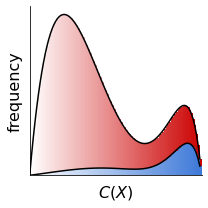

In [36]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

# simulate the data
x_axis = np.arange (0, 1, bin_size)

# positive density function
pos_y_density = lam * stats.beta.pdf(x_axis, pos_a, pos_b) + (1 - lam) * stats.uniform.pdf(x_axis)

# negative density function
neg_y_density = lam * stats.beta.pdf(x_axis, neg_a, neg_b) + (1 - lam) * stats.uniform.pdf(x_axis)

overall_y_density = []
pos_est_density = []

for transpancy, x, pos_y, neg_y in zip(range(num_bin), x_axis, pos_y_density, neg_y_density):
    point_overall_y_density = p_p * pos_y + p_n * neg_y
    overall_y_density.append(point_overall_y_density)
    
    positive_rate = calibration_func.predict_proba(np.array([x]).reshape(-1, 1)).ravel()[-1]
    point_estimated_positive = positive_rate * point_overall_y_density
    pos_est_density.append(point_estimated_positive)

    ax.fill_between([x, x+bin_size], [0, 0], 
                    point_estimated_positive, 
                    facecolor=tp_color, alpha=transpancy/num_bin, lw=0)

    ax.fill_between([x, x+bin_size], [point_overall_y_density, point_overall_y_density], 
                    point_estimated_positive, 
                    facecolor=fp_color, alpha=transpancy/num_bin, lw=0)

ax.plot(x_axis, overall_y_density, 'k', lw=1.5)
ax.plot(x_axis, pos_est_density, 'k', lw=1.5)

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
# plt.savefig('fig3d.png', dpi=1000)

In [19]:
threshold = 0.7

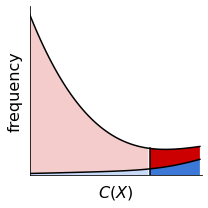

In [20]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

# simulate the data
x_axis = np.arange (0, 1, bin_size)

# positive density function
pos_y_density = lam * stats.beta.pdf(x_axis, pos_a, pos_b) + (1 - lam) * stats.uniform.pdf(x_axis)

# negative density function
neg_y_density = lam * stats.beta.pdf(x_axis, neg_a, neg_b) + (1 - lam) * stats.uniform.pdf(x_axis)

overall_y_density = []
pos_est_density = []

left_threshold_x_axis = []
left_threshold_y_mid_axis = []
left_threshold_y_up_axis = []
right_threshold_x_axis = []
right_threshold_y_mid_axis = []
right_threshold_y_up_axis = []

for transpancy, x, pos_y, neg_y in zip(range(num_bin), x_axis, pos_y_density, neg_y_density):
    point_overall_y_density = p_p * pos_y + p_n * neg_y
    overall_y_density.append(point_overall_y_density)
    
    positive_rate = calibration_func.predict_proba(np.array([x]).reshape(-1, 1)).ravel()[-1]
    point_estimated_positive = positive_rate * point_overall_y_density
    pos_est_density.append(point_estimated_positive)
    
    if x < threshold:
        left_threshold_x_axis.append(x)
        left_threshold_y_mid_axis.append(point_estimated_positive)
        left_threshold_y_up_axis.append(point_overall_y_density)
    else:
        right_threshold_x_axis.append(x)
        right_threshold_y_mid_axis.append(point_estimated_positive)
        right_threshold_y_up_axis.append(point_overall_y_density)
            
    if transpancy == int(100 * threshold):
        ax.plot([threshold, threshold], [0, point_overall_y_density], 'k-', zorder=50)

ax.fill_between(left_threshold_x_axis, [0] * len(left_threshold_x_axis), 
                left_threshold_y_mid_axis, 
                facecolor=fn_color, lw=0)

ax.fill_between(right_threshold_x_axis, [0] * len(right_threshold_x_axis), 
                right_threshold_y_mid_axis, 
                facecolor=tp_color, lw=0)

ax.fill_between(left_threshold_x_axis, left_threshold_y_up_axis, 
                left_threshold_y_mid_axis, 
                facecolor=tn_color, lw=0)

ax.fill_between(right_threshold_x_axis, right_threshold_y_up_axis, 
                right_threshold_y_mid_axis, 
                facecolor=fp_color, lw=0)

ax.plot(x_axis, overall_y_density, 'k')
ax.plot(x_axis, pos_est_density, 'k')

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig('fig3d2.png', dpi=1000)

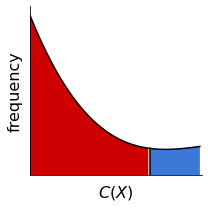

In [21]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

# simulate the data
x_axis = np.arange (0, 1, bin_size)

# positive density function
pos_y_density = lam * stats.beta.pdf(x_axis, pos_a, pos_b) + (1 - lam) * stats.uniform.pdf(x_axis)

# negative density function
neg_y_density = lam * stats.beta.pdf(x_axis, neg_a, neg_b) + (1 - lam) * stats.uniform.pdf(x_axis)

overall_y_density = []
pos_est_density = []

left_threshold_x_axis = []
left_threshold_y_mid_axis = []
left_threshold_y_up_axis = []
right_threshold_x_axis = []
right_threshold_y_mid_axis = []
right_threshold_y_up_axis = []

for transpancy, x, pos_y, neg_y in zip(range(num_bin), x_axis, pos_y_density, neg_y_density):
    point_overall_y_density = p_p * pos_y + p_n * neg_y
    overall_y_density.append(point_overall_y_density)
    
    positive_rate = calibration_func.predict_proba(np.array([x]).reshape(-1, 1)).ravel()[-1]
    point_estimated_positive = positive_rate * point_overall_y_density
    pos_est_density.append(point_estimated_positive)
    
    if x < threshold:
        left_threshold_x_axis.append(x)
        left_threshold_y_mid_axis.append(point_estimated_positive)
        left_threshold_y_up_axis.append(point_overall_y_density)
    else:
        right_threshold_x_axis.append(x)
        right_threshold_y_mid_axis.append(point_estimated_positive)
        right_threshold_y_up_axis.append(point_overall_y_density)
            
    if transpancy == int(100 * threshold):
        ax.plot([threshold, threshold], [0, point_overall_y_density], 'k-', zorder=50)

ax.fill_between(left_threshold_x_axis, [0] * len(left_threshold_x_axis), 
                left_threshold_y_up_axis, 
                facecolor=fp_color, lw=0)

ax.fill_between(right_threshold_x_axis, [0] * len(right_threshold_x_axis), 
                right_threshold_y_up_axis, 
                facecolor=tp_color, lw=0)

# ax.fill_between(left_threshold_x_axis, left_threshold_y_up_axis, 
#                 left_threshold_y_mid_axis, 
#                 facecolor=tn_color, lw=0)

# ax.fill_between(right_threshold_x_axis, right_threshold_y_up_axis, 
#                 right_threshold_y_mid_axis, 
#                 facecolor=fp_color, lw=0)

ax.plot(x_axis, overall_y_density, 'k')
# ax.plot(x_axis, pos_est_density, 'k')

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
# plt.savefig('fig3d2.png', dpi=1000)

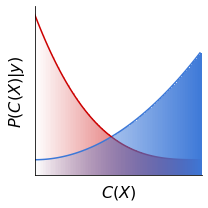

In [22]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

# simulate the data
x_axis = np.arange (0, 1, bin_size)

# positive density function
pos_y_density = lam * stats.beta.pdf(x_axis, pos_a, pos_b) + (1 - lam) * stats.uniform.pdf(x_axis)

# negative density function
neg_y_density = lam * stats.beta.pdf(x_axis, neg_a, neg_b) + (1 - lam) * stats.uniform.pdf(x_axis)

for transpancy, x, pos_y, neg_y in zip(range(num_bin), x_axis, pos_y_density, neg_y_density):    
    ax.fill_between([x, x+bin_size], [0, 0], 
                    [pos_y], 
                    facecolor=tp_color, alpha=transpancy/num_bin, lw=1, zorder=40)

    ax.fill_between([x, x+bin_size], [0, 0], 
                    [neg_y], 
                    facecolor=fp_color, alpha=transpancy/num_bin, lw=1)

ax.plot(x_axis, pos_y_density, c=tp_color)
ax.plot(x_axis, neg_y_density, c=fp_color)

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('$P(C(X)|y)$', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig('fig3e.png', dpi=1000)

# data simulator for the tutorial

A joint distribution can be discomposed into two kinds of plots:
- $X -> Y$ problem: Frequency plot + calibration curve
- $Y -> X$ problem: Positive and negative density function and ratio of positive and negative classes
    * You have democratic ($-$) and republicans ($+$), each assume that each person behaves the same, they all have the same probability distribution to post a negative comment toward the Democratics Party.
        * This can be captured by two Beta distribution, for each, Beta(5, 2) and Beta(1, 3) for each.

What we want?

A function of four parameters $\alpha, \beta, w, b$, where $\alpha$ and $\beta$ specify the shape of the frequency distribution ($Beta$ distribution) and $w$ and $b$ specify the calibration curve.

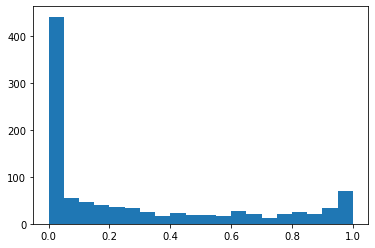

In [74]:
# Specify the parameters of the beta distribution
alpha = 0.2
beta = 0.5

# Generate a random sample from the beta distribution
samples = np.random.beta(alpha, beta, size=1000)

# Plot the distribution of the samples
plt.hist(samples, bins=20)
plt.show()

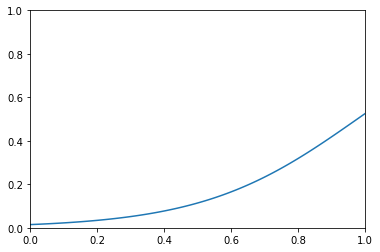

In [72]:
w = -4.3
b = 4.2

x_axis = np.linspace(0, 1, 100)

y_axis = [sigmoid(w * x + b) for x in x_axis]

plt.plot(x_axis, y_axis)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

## Extrapolation Phase

In [22]:
target_p_p = 0.3
target_p_n = 1 - target_p_p

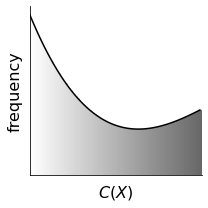

In [23]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

# simulate the data
x_axis = np.arange (0, 1, bin_size)

# positive density function
pos_y_density = lam * stats.beta.pdf(x_axis, pos_a, pos_b) + (1 - lam) * stats.uniform.pdf(x_axis)

# negative density function
neg_y_density = lam * stats.beta.pdf(x_axis, neg_a, neg_b) + (1 - lam) * stats.uniform.pdf(x_axis)

overall_y_density = []

for transpancy, x, pos_y, neg_y in zip(range(num_bin), x_axis, pos_y_density, neg_y_density):
    point_overall_y_density = target_p_p * pos_y + target_p_n * neg_y
    overall_y_density.append(point_overall_y_density)
    
    ax.fill_between([x, x+bin_size], [0, 0], 
                    [point_overall_y_density], 
                    facecolor=dark_gray_color, alpha=transpancy/num_bin, lw=0)

ax.plot(x_axis, overall_y_density, 'k')

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig('fig3f.png', dpi=1000)

/Users/siqiwu/Developments/env/anaconda3/envs/hot/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


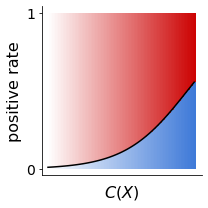

In [24]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

size_base = len(base_scores)

np.random.seed(47)
sampled_idx = np.random.choice(range(size_base), 50)

pos_scores = [base_scores[x] for x in sampled_idx if base_labels[x]]
pos_labels = [base_labels[x] for x in sampled_idx if base_labels[x]]
neg_scores = [base_scores[x] for x in sampled_idx if not base_labels[x]]
neg_labels = [base_labels[x] for x in sampled_idx if not base_labels[x]]

x_axis = np.arange(0, 1, bin_size)

calibration_func = LogisticRegression(fit_intercept=True).fit(np.array(base_scores).reshape(-1, 1), np.array(base_labels).reshape(-1, 1))
calibration_curve = calibration_func.predict_proba(x_axis.reshape(-1, 1))[:, -1]

ax.plot(x_axis, calibration_curve, 'k', zorder=50)

# simulate the data
x_axis = np.arange (0, 1, bin_size)

for transpancy, x, calibration_point in zip(range(num_bin), x_axis, calibration_curve):    
    ax.fill_between([x, x+bin_size], [0, 0], 
                    calibration_point, 
                    facecolor=tp_color, alpha=transpancy/num_bin, lw=0)
    ax.fill_between([x, x+bin_size], [1, 1], 
                    calibration_point, 
                    facecolor=fp_color, alpha=transpancy/num_bin, lw=0)

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('positive rate', fontsize=16)
ax.set_xlim([-0.04, 1.04])
ax.set_ylim([-0.04, 1.04])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([0, 1])
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig('fig3g1.png', dpi=1000)

/Users/siqiwu/Developments/env/anaconda3/envs/hot/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


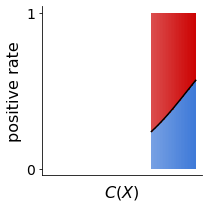

In [25]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

size_base = len(base_scores)

np.random.seed(47)
sampled_idx = np.random.choice(range(size_base), 50)

pos_scores = [base_scores[x] for x in sampled_idx if base_labels[x]]
pos_labels = [base_labels[x] for x in sampled_idx if base_labels[x]]
neg_scores = [base_scores[x] for x in sampled_idx if not base_labels[x]]
neg_labels = [base_labels[x] for x in sampled_idx if not base_labels[x]]

x_axis = np.arange (0, 1, bin_size)
half_axis = np.arange(threshold, 1, bin_size)

calibration_func = LogisticRegression(fit_intercept=True).fit(np.array(base_scores).reshape(-1, 1), np.array(base_labels).reshape(-1, 1))
calibration_curve = calibration_func.predict_proba(x_axis.reshape(-1, 1))[:, -1]
half_calibration_curve = calibration_func.predict_proba(half_axis.reshape(-1, 1))[:, -1]

ax.plot(half_axis, half_calibration_curve, 'k', zorder=50)

for transpancy, x, calibration_point in zip(range(num_bin), x_axis, calibration_curve):    
    if x > threshold:
        ax.fill_between([x, x+bin_size], [0, 0], 
                        calibration_point, 
                        facecolor=tp_color, alpha=transpancy/num_bin, lw=0)
        ax.fill_between([x, x+bin_size], [1, 1], 
                        calibration_point, 
                        facecolor=fp_color, alpha=transpancy/num_bin, lw=0)

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('positive rate', fontsize=16)
ax.set_xlim([-0.04, 1.04])
ax.set_ylim([-0.04, 1.04])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([0, 1])
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig('fig3g3.png', dpi=1000)

/Users/siqiwu/Developments/env/anaconda3/envs/hot/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


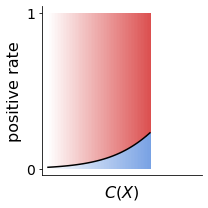

In [26]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

size_base = len(base_scores)

np.random.seed(47)
sampled_idx = np.random.choice(range(size_base), 50)

pos_scores = [base_scores[x] for x in sampled_idx if base_labels[x]]
pos_labels = [base_labels[x] for x in sampled_idx if base_labels[x]]
neg_scores = [base_scores[x] for x in sampled_idx if not base_labels[x]]
neg_labels = [base_labels[x] for x in sampled_idx if not base_labels[x]]

x_axis = np.arange (0, 1, bin_size)
half_axis = np.arange(0, threshold, bin_size)

calibration_func = LogisticRegression(fit_intercept=True).fit(np.array(base_scores).reshape(-1, 1), np.array(base_labels).reshape(-1, 1))
calibration_curve = calibration_func.predict_proba(x_axis.reshape(-1, 1))[:, -1]
half_calibration_curve = calibration_func.predict_proba(half_axis.reshape(-1, 1))[:, -1]

ax.plot(half_axis, half_calibration_curve, 'k', zorder=50)

for transpancy, x, calibration_point in zip(range(num_bin), x_axis, calibration_curve):    
    if x < threshold:
        ax.fill_between([x, x+bin_size], [0, 0], 
                        calibration_point, 
                        facecolor=tp_color, alpha=transpancy/num_bin, lw=0)
        ax.fill_between([x, x+bin_size], [1, 1], 
                        calibration_point, 
                        facecolor=fp_color, alpha=transpancy/num_bin, lw=0)

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('positive rate', fontsize=16)
ax.set_xlim([-0.04, 1.04])
ax.set_ylim([-0.04, 1.04])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([0, 1])
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig('fig3g4.png', dpi=1000)

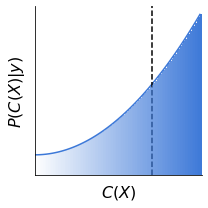

In [27]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

# simulate the data
x_axis = np.arange (0, 1, bin_size)

# positive density function
pos_y_density = lam * stats.beta.pdf(x_axis, pos_a, pos_b) + (1 - lam) * stats.uniform.pdf(x_axis)

for transpancy, x, pos_y, neg_y in zip(range(num_bin), x_axis, pos_y_density, neg_y_density):    
    ax.fill_between([x, x+bin_size], [0, 0], 
                    [pos_y], 
                    facecolor=tp_color, alpha=transpancy/num_bin, lw=1, zorder=40)

ax.plot(x_axis, pos_y_density, c=tp_color)
ax.axvline(x=threshold, c='k', ls='--')

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('$P(C(X)|y)$', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig('fig3g32.png', dpi=1000)

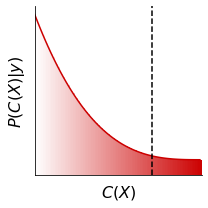

In [28]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

# simulate the data
x_axis = np.arange (0, 1, bin_size)

# negative density function
neg_y_density = lam * stats.beta.pdf(x_axis, neg_a, neg_b) + (1 - lam) * stats.uniform.pdf(x_axis)

for transpancy, x, pos_y, neg_y in zip(range(num_bin), x_axis, pos_y_density, neg_y_density):    
    ax.fill_between([x, x+bin_size], [0, 0], 
                    [neg_y], 
                    facecolor=fp_color, alpha=transpancy/num_bin, lw=1)

ax.plot(x_axis, neg_y_density, c=fp_color)
ax.axvline(x=threshold, c='k', ls='--')

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('$P(C(X)|y)$', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig('fig3g42.png', dpi=1000)

estimated prevalence: 0.1351


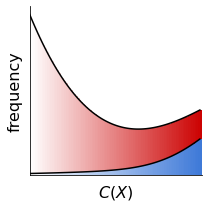

In [29]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

# simulate the data
x_axis = np.arange (0, 1, bin_size)

# positive density function
pos_y_density = lam * stats.beta.pdf(x_axis, pos_a, pos_b) + (1 - lam) * stats.uniform.pdf(x_axis)

# negative density function
neg_y_density = lam * stats.beta.pdf(x_axis, neg_a, neg_b) + (1 - lam) * stats.uniform.pdf(x_axis)

overall_y_density = []
pos_est_density = []

for transpancy, x, pos_y, neg_y in zip(range(num_bin), x_axis, pos_y_density, neg_y_density):
    point_overall_y_density = target_p_p * pos_y + target_p_n * neg_y
    overall_y_density.append(point_overall_y_density)
    
    positive_rate = calibration_func.predict_proba(np.array([x]).reshape(-1, 1)).ravel()[-1]
    point_estimated_positive = positive_rate * point_overall_y_density
    pos_est_density.append(point_estimated_positive)

    ax.fill_between([x, x+bin_size], [0, 0], 
                    point_estimated_positive, 
                    facecolor=tp_color, alpha=transpancy/num_bin, lw=0)

    ax.fill_between([x, x+bin_size], [point_overall_y_density, point_overall_y_density], 
                    point_estimated_positive, 
                    facecolor=fp_color, alpha=transpancy/num_bin, lw=0)

ax.plot(x_axis, overall_y_density, 'k')
ax.plot(x_axis, pos_est_density, 'k')

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig('fig3h1.png', dpi=1000)

print(f'estimated prevalence: {sum(pos_est_density) / sum(overall_y_density):.4f}')

estimated prevalence: 0.0974


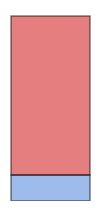

In [30]:
ep = 0.1368
fig = plt.figure(figsize=(1.5, 3))
ax = fig.add_subplot(111)

ax.bar(['$C(X)$'], [ep], fc=tp_color, ec='k', alpha=0.5, linewidth=1.5)
ax.bar(['$C(X)$'], [1-ep], fc=fp_color, ec='k', alpha=0.5, linewidth=1.5, bottom=[ep])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

print(f'estimated prevalence: {(sum(left_threshold_y_mid_axis) + sum(right_threshold_y_mid_axis)) / sum(overall_y_density):.4f}')
plt.axis('off')

plt.tight_layout()
plt.savefig('fig3i1.png', dpi=1000)

estimated prevalence: 0.1664


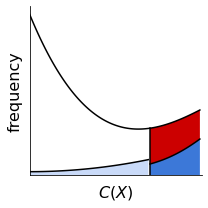

In [31]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

# simulate the data
x_axis = np.arange (0, 1, bin_size)

# positive density function
pos_y_density = lam * stats.beta.pdf(x_axis, pos_a, pos_b) + (1 - lam) * stats.uniform.pdf(x_axis)

# negative density function
neg_y_density = lam * stats.beta.pdf(x_axis, neg_a, neg_b) + (1 - lam) * stats.uniform.pdf(x_axis)

overall_y_density = []
pos_est_density = []

left_threshold_x_axis = []
left_threshold_y_mid_axis = []
left_threshold_y_up_axis = []
right_threshold_x_axis = []
right_threshold_y_mid_axis = []
right_threshold_y_up_axis = []

link_area = 0

for transpancy, x, pos_y, neg_y in zip(range(num_bin), x_axis, pos_y_density, neg_y_density):
    point_overall_y_density = target_p_p * pos_y + target_p_n * neg_y
    overall_y_density.append(point_overall_y_density)

    if x > threshold:
        right_threshold_x_axis.append(x)
        right_threshold_y_up_axis.append(point_overall_y_density)

        positive_rate = calibration_func.predict_proba(np.array([x]).reshape(-1, 1)).ravel()[-1]
        point_estimated_positive = positive_rate * point_overall_y_density
        right_threshold_y_mid_axis.append(point_estimated_positive)
        link_area += point_estimated_positive
    elif x < threshold:
        left_threshold_x_axis.append(x)
        left_threshold_y_up_axis.append(point_overall_y_density)
        
    if transpancy == int(100 * threshold):
        ax.plot([threshold, threshold], [0, point_overall_y_density], 'k-', zorder=50)

total_pos_left_rate = sum([y for x, y in zip(x_axis, pos_y_density) if x < threshold])
total_pos_right_rate = sum([y for x, y in zip(x_axis, pos_y_density) if x > threshold])

scale = link_area / total_pos_right_rate

for x, pos_y in zip(x_axis, pos_y_density):
    if x < threshold:
        left_threshold_y_mid_axis.append(pos_y * scale)

ax.fill_between(left_threshold_x_axis, [0] * len(left_threshold_x_axis), 
                left_threshold_y_mid_axis, 
                facecolor=fn_color, lw=0)

ax.fill_between(right_threshold_x_axis, [0] * len(right_threshold_x_axis), 
                right_threshold_y_mid_axis, 
                facecolor=tp_color, lw=0)

ax.fill_between(right_threshold_x_axis, right_threshold_y_up_axis, 
                right_threshold_y_mid_axis, 
                facecolor=fp_color, lw=0)

ax.plot(x_axis, overall_y_density, 'k')
ax.plot(left_threshold_x_axis, left_threshold_y_mid_axis, 'k')
ax.plot(right_threshold_x_axis, right_threshold_y_mid_axis, 'k')

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

print(f'estimated prevalence: {(sum(left_threshold_y_mid_axis) + sum(right_threshold_y_mid_axis)) / sum(overall_y_density):.4f}')

plt.tight_layout()
plt.savefig('fig3h3.png', dpi=1000)

estimated prevalence: 0.1664


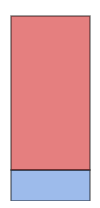

In [32]:
ep = 0.1686
fig = plt.figure(figsize=(1.5, 3))
ax = fig.add_subplot(111)

ax.bar(['$C(X)$'], [ep], fc=tp_color, ec='k', alpha=0.5, linewidth=1.5)
ax.bar(['$C(X)$'], [1-ep], fc=fp_color, ec='k', alpha=0.5, linewidth=1.5, bottom=[ep])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

print(f'estimated prevalence: {(sum(left_threshold_y_mid_axis) + sum(right_threshold_y_mid_axis)) / sum(overall_y_density):.4f}')
plt.axis('off')

plt.tight_layout()
plt.savefig('fig3i3.png', dpi=1000)

estimated prevalence: 0.1965


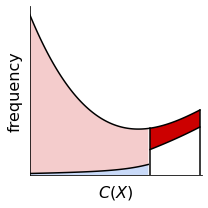

In [33]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

# simulate the data
x_axis = np.arange (0, 1, bin_size)

# positive density function
pos_y_density = lam * stats.beta.pdf(x_axis, pos_a, pos_b) + (1 - lam) * stats.uniform.pdf(x_axis)

# negative density function
neg_y_density = lam * stats.beta.pdf(x_axis, neg_a, neg_b) + (1 - lam) * stats.uniform.pdf(x_axis)

overall_y_density = []
pos_est_density = []

left_threshold_x_axis = []
left_threshold_y_mid_axis = []
left_threshold_y_up_axis = []
right_threshold_x_axis = []
right_threshold_y_mid_axis = []
right_threshold_y_up_axis = []

link_area = 0

for transpancy, x, pos_y, neg_y in zip(range(num_bin), x_axis, pos_y_density, neg_y_density):
    point_overall_y_density = target_p_p * pos_y + target_p_n * neg_y
    overall_y_density.append(point_overall_y_density)

    if x < threshold:
        left_threshold_x_axis.append(x)
        left_threshold_y_up_axis.append(point_overall_y_density)

        positive_rate = calibration_func.predict_proba(np.array([x]).reshape(-1, 1)).ravel()[-1]
        point_estimated_positive = positive_rate * point_overall_y_density
        point_estimated_negative = (1 - positive_rate) * point_overall_y_density
        left_threshold_y_mid_axis.append(point_estimated_positive)
        link_area += point_estimated_negative
    elif x > threshold:
        right_threshold_x_axis.append(x)
        right_threshold_y_up_axis.append(point_overall_y_density)
        
    if transpancy == int(100 * threshold):
        ax.plot([threshold, threshold], [0, point_overall_y_density], 'k-', zorder=50)

total_neg_left_rate = sum([y for x, y in zip(x_axis, neg_y_density) if x < threshold])
total_neg_right_rate = sum([y for x, y in zip(x_axis, neg_y_density) if x > threshold])

scale = link_area / total_neg_left_rate

for x, pos_y, neg_y in zip(x_axis, pos_y_density, neg_y_density):
    point_overall_y_density = target_p_p * pos_y + target_p_n * neg_y
    if x > threshold:
        right_threshold_y_mid_axis.append(point_overall_y_density - neg_y * scale)

ax.fill_between(left_threshold_x_axis, [0] * len(left_threshold_x_axis), 
                left_threshold_y_mid_axis, 
                facecolor=fn_color, lw=0)

ax.fill_between(left_threshold_x_axis, left_threshold_y_up_axis, 
                left_threshold_y_mid_axis, 
                facecolor=tn_color, lw=0)

# ax.fill_between(right_threshold_x_axis, [0] * len(right_threshold_x_axis), 
#                 right_threshold_y_mid_axis, 
#                 facecolor=tp_color, lw=0)

ax.fill_between(right_threshold_x_axis, right_threshold_y_up_axis, 
                right_threshold_y_mid_axis, 
                facecolor=fp_color, lw=0)

ax.plot(x_axis, overall_y_density, 'k')
ax.plot(left_threshold_x_axis, left_threshold_y_mid_axis, 'k')
ax.plot(right_threshold_x_axis, right_threshold_y_mid_axis, 'k')
ax.plot([0.99, 0.99], [0, overall_y_density[-1]], 'k')

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

print(f'estimated prevalence: {(sum(left_threshold_y_mid_axis) + sum(right_threshold_y_mid_axis)) / sum(overall_y_density):.4f}')

plt.tight_layout()
plt.savefig('fig3h4.png', dpi=1000)

estimated prevalence: 0.1965


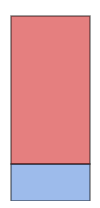

In [34]:
ep = 0.1971
fig = plt.figure(figsize=(1.5, 3))
ax = fig.add_subplot(111)

ax.bar(['$C(X)$'], [ep], fc=tp_color, ec='k', alpha=0.5, linewidth=1.5)
ax.bar(['$C(X)$'], [1-ep], fc=fp_color, ec='k', alpha=0.5, linewidth=1.5, bottom=[ep])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

print(f'estimated prevalence: {(sum(left_threshold_y_mid_axis) + sum(right_threshold_y_mid_axis)) / sum(overall_y_density):.4f}')
plt.axis('off')

plt.tight_layout()
plt.savefig('fig3i4.png', dpi=1000)

estimated prevalence: -0.4513


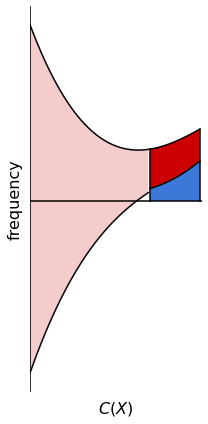

In [35]:
fig = plt.figure(figsize=(3, 6))
ax = fig.add_subplot(111)

# simulate the data
x_axis = np.arange (0, 1, bin_size)

# positive density function
pos_y_density = lam * stats.beta.pdf(x_axis, pos_a, pos_b) + (1 - lam) * stats.uniform.pdf(x_axis)

# negative density function
neg_y_density = lam * stats.beta.pdf(x_axis, neg_a, neg_b) + (1 - lam) * stats.uniform.pdf(x_axis)

overall_y_density = []
pos_est_density = []

left_threshold_x_axis = []
left_threshold_y_mid_axis = []
left_threshold_y_up_axis = []
right_threshold_x_axis = []
right_threshold_y_mid_axis = []
right_threshold_y_up_axis = []

link_area = 0

for transpancy, x, pos_y, neg_y in zip(range(num_bin), x_axis, pos_y_density, neg_y_density):
    point_overall_y_density = target_p_p * pos_y + target_p_n * neg_y
    overall_y_density.append(point_overall_y_density)

    if x > threshold:
        right_threshold_x_axis.append(x)
        right_threshold_y_up_axis.append(point_overall_y_density)

        positive_rate = calibration_func.predict_proba(np.array([x]).reshape(-1, 1)).ravel()[-1]
        point_estimated_positive = positive_rate * point_overall_y_density
        right_threshold_y_mid_axis.append(point_estimated_positive)
        link_area += (point_overall_y_density - point_estimated_positive)
    elif x < threshold:
        left_threshold_x_axis.append(x)
        left_threshold_y_up_axis.append(point_overall_y_density)
        
    if transpancy == int(100 * threshold):
        ax.plot([threshold, threshold], [0, point_overall_y_density], 'k-', zorder=50)

total_neg_left_rate = sum([y for x, y in zip(x_axis, neg_y_density) if x < threshold])
total_neg_right_rate = sum([y for x, y in zip(x_axis, neg_y_density) if x > threshold])

scale = link_area / total_neg_right_rate

for x, pos_y, neg_y in zip(x_axis, pos_y_density, neg_y_density):
    point_overall_y_density = target_p_p * pos_y + target_p_n * neg_y
    if x < threshold:
        left_threshold_y_mid_axis.append(point_overall_y_density - neg_y * scale)

# ax.fill_between(left_threshold_x_axis, [0] * len(left_threshold_x_axis), 
#                 left_threshold_y_mid_axis, 
#                 facecolor=fn_color, lw=0)

ax.fill_between(left_threshold_x_axis, left_threshold_y_up_axis, 
                left_threshold_y_mid_axis, 
                facecolor=tn_color, lw=0)

ax.fill_between(right_threshold_x_axis, [0] * len(right_threshold_x_axis), 
                right_threshold_y_mid_axis, 
                facecolor=tp_color, lw=0)

ax.fill_between(right_threshold_x_axis, right_threshold_y_up_axis, 
                right_threshold_y_mid_axis, 
                facecolor=fp_color, lw=0)

ax.plot(x_axis, overall_y_density, 'k')
ax.plot(left_threshold_x_axis, left_threshold_y_mid_axis, 'k')
ax.plot(right_threshold_x_axis, right_threshold_y_mid_axis, 'k')
ax.plot([0.99, 0.99], [0, overall_y_density[-1]], 'k')
ax.axhline(y=0, c='k')

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
ax.set_xlim([0, 1])
# ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

print(f'estimated prevalence: {(sum(left_threshold_y_mid_axis) + sum(right_threshold_y_mid_axis)) / sum(overall_y_density):.4f}')

plt.tight_layout()
plt.savefig('fig3h5.png', dpi=1000)

estimated prevalence: 0.0968


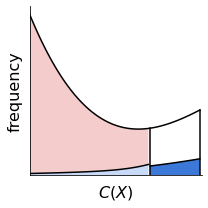

In [36]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

# simulate the data
x_axis = np.arange (0, 1, bin_size)

# positive density function
pos_y_density = lam * stats.beta.pdf(x_axis, pos_a, pos_b) + (1 - lam) * stats.uniform.pdf(x_axis)

# negative density function
neg_y_density = lam * stats.beta.pdf(x_axis, neg_a, neg_b) + (1 - lam) * stats.uniform.pdf(x_axis)

overall_y_density = []
pos_est_density = []

left_threshold_x_axis = []
left_threshold_y_mid_axis = []
left_threshold_y_up_axis = []
right_threshold_x_axis = []
right_threshold_y_mid_axis = []
right_threshold_y_up_axis = []

link_area = 0

for transpancy, x, pos_y, neg_y in zip(range(num_bin), x_axis, pos_y_density, neg_y_density):
    point_overall_y_density = target_p_p * pos_y + target_p_n * neg_y
    overall_y_density.append(point_overall_y_density)

    if x < threshold:
        left_threshold_x_axis.append(x)
        left_threshold_y_up_axis.append(point_overall_y_density)

        positive_rate = calibration_func.predict_proba(np.array([x]).reshape(-1, 1)).ravel()[-1]
        point_estimated_positive = positive_rate * point_overall_y_density
        left_threshold_y_mid_axis.append(point_estimated_positive)
        link_area += point_estimated_positive
    elif x > threshold:
        right_threshold_x_axis.append(x)
        right_threshold_y_up_axis.append(point_overall_y_density)
        
    if transpancy == int(100 * threshold):
        ax.plot([threshold, threshold], [0, point_overall_y_density], 'k-', zorder=50)

total_pos_left_rate = sum([y for x, y in zip(x_axis, pos_y_density) if x < threshold])
total_pos_right_rate = sum([y for x, y in zip(x_axis, pos_y_density) if x > threshold])

scale = link_area / total_pos_left_rate

for x, pos_y in zip(x_axis, pos_y_density):
    if x > threshold:
        right_threshold_y_mid_axis.append(pos_y * scale)

ax.fill_between(left_threshold_x_axis, [0] * len(left_threshold_x_axis), 
                left_threshold_y_mid_axis, 
                facecolor=fn_color, lw=0)

ax.fill_between(left_threshold_x_axis, left_threshold_y_up_axis, 
                left_threshold_y_mid_axis, 
                facecolor=tn_color, lw=0)

ax.fill_between(right_threshold_x_axis, [0] * len(right_threshold_x_axis), 
                right_threshold_y_mid_axis, 
                facecolor=tp_color, lw=0)

# ax.fill_between(right_threshold_x_axis, right_threshold_y_up_axis, 
#                 right_threshold_y_mid_axis, 
#                 facecolor=fp_color, lw=0)

ax.plot(x_axis, overall_y_density, 'k')
ax.plot(left_threshold_x_axis, left_threshold_y_mid_axis, 'k')
ax.plot(right_threshold_x_axis, right_threshold_y_mid_axis, 'k')
ax.plot([0.99, 0.99], [0, overall_y_density[-1]], 'k')

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

print(f'estimated prevalence: {(sum(left_threshold_y_mid_axis) + sum(right_threshold_y_mid_axis)) / sum(overall_y_density):.4f}')

plt.tight_layout()
plt.savefig('fig3h6.png', dpi=1000)

estimated prevalence: 0.0968


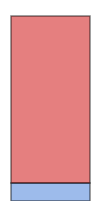

In [37]:
ep = 0.0980
fig = plt.figure(figsize=(1.5, 3))
ax = fig.add_subplot(111)

ax.bar(['$C(X)$'], [ep], fc=tp_color, ec='k', alpha=0.5, linewidth=1.5)
ax.bar(['$C(X)$'], [1-ep], fc=fp_color, ec='k', alpha=0.5, linewidth=1.5, bottom=[ep])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

print(f'estimated prevalence: {(sum(left_threshold_y_mid_axis) + sum(right_threshold_y_mid_axis)) / sum(overall_y_density):.4f}')
plt.axis('off')

plt.tight_layout()
plt.savefig('fig3i6.png', dpi=1000)

In [38]:
# simulate the data
x_axis = np.arange (0, 1, bin_size)

# positive density function
pos_y_density = lam * stats.beta.pdf(x_axis, pos_a, pos_b) + (1 - lam) * stats.uniform.pdf(x_axis)

# negative density function
neg_y_density = lam * stats.beta.pdf(x_axis, neg_a, neg_b) + (1 - lam) * stats.uniform.pdf(x_axis)

overall_y_density = []
pos_est_density = []

for transpancy, x, pos_y, neg_y in zip(range(num_bin), x_axis, pos_y_density, neg_y_density):
    point_overall_y_density = target_p_p * pos_y + target_p_n * neg_y
    overall_y_density.append(point_overall_y_density)


best_ep_t = 0
minimal_dist = 1
for ep_t in np.arange (0, 1, bin_size):
    bootstrap_overall_y_density = []
    for x, pos_y, neg_y in zip(x_axis, pos_y_density, neg_y_density):
        point_est_pdf = ep_t * pos_y + (1-ep_t) * neg_y
        bootstrap_overall_y_density.append(point_est_pdf)
    
    bootstrap_overall_y_density = np.array(bootstrap_overall_y_density)
    bootstrap_overall_y_density /= bootstrap_overall_y_density
    overall_y_density = np.array(overall_y_density)
    overall_y_density /= overall_y_density
        
    dist = hellinger(overall_y_density, est_pdf)
    if dist < minimal_dist:
        minimal_dist = dist
        best_ep_t = ep_t
print('best_prevalence', best_prevalence)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

# simulate the data
x_axis = np.arange (0, 1, bin_size)

# positive density function
pos_y_density = lam * stats.beta.pdf(x_axis, pos_a, pos_b) + (1 - lam) * stats.uniform.pdf(x_axis)

# negative density function
neg_y_density = lam * stats.beta.pdf(x_axis, neg_a, neg_b) + (1 - lam) * stats.uniform.pdf(x_axis)

overall_y_density = []
pos_est_density = []

for transpancy, x, pos_y, neg_y in zip(range(num_bin), x_axis, pos_y_density, neg_y_density):
    point_overall_y_density = best_prevalence * pos_y + best_prevalence * neg_y
    overall_y_density.append(point_overall_y_density)
    
    positive_rate = calibration_func.predict_proba(np.array([x]).reshape(-1, 1)).ravel()[-1]
    point_estimated_positive = positive_rate * point_overall_y_density
    pos_est_density.append(point_estimated_positive)

    ax.fill_between([x, x+bin_size], [0, 0], 
                    point_estimated_positive, 
                    facecolor=tp_color, alpha=transpancy/num_bin, lw=0)

    ax.fill_between([x, x+bin_size], [point_overall_y_density, point_overall_y_density], 
                    point_estimated_positive, 
                    facecolor=fp_color, alpha=transpancy/num_bin, lw=0)

ax.plot(x_axis, overall_y_density, 'k')
ax.plot(x_axis, pos_est_density, 'k')

ax.set_xlabel('$C(X)$', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim(ymin=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig('fig3i2.png', dpi=1000)

print(f'estimated prevalence: {sum(pos_est_density) / sum(overall_y_density):.4f}')

    
#     point_estimated_positive = positive_rate * point_overall_y_density
#     pos_est_density.append(point_estimated_positive)

#     ax.fill_between([x, x+bin_size], [0, 0], 
#                     point_estimated_positive, 
#                     facecolor=tp_color, alpha=transpancy/num_bin, lw=0)

#     ax.fill_between([x, x+bin_size], [point_overall_y_density, point_overall_y_density], 
#                     point_estimated_positive, 
#                     facecolor=fp_color, alpha=transpancy/num_bin, lw=0)

# ax.plot(x_axis, overall_y_density, 'k')
# ax.plot(x_axis, pos_est_density, 'k')

# ax.set_xlabel('$C(X)$', fontsize=16)
# ax.set_ylabel('frequency', fontsize=16)
# ax.set_xlim([0, 1])
# ax.set_ylim(ymin=0)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.set_xticks([])
# ax.set_yticks([])

# plt.tight_layout()
# plt.savefig('fig3h2.png', dpi=1000)

# print(f'estimated prevalence: {sum(pos_est_density) / sum(overall_y_density):.4f}')

NameError: name 'est_pdf' is not defined

In [ ]:
ep = 0.0980
fig = plt.figure(figsize=(1.5, 3))
ax = fig.add_subplot(111)

ax.bar(['$C(X)$'], [ep], fc=tp_color, ec='k', alpha=0.5, linewidth=1.5)
ax.bar(['$C(X)$'], [1-ep], fc=fp_color, ec='k', alpha=0.5, linewidth=1.5, bottom=[ep])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

print(f'estimated prevalence: {(sum(left_threshold_y_mid_axis) + sum(right_threshold_y_mid_axis)) / sum(overall_y_density):.4f}')
plt.axis('off')

plt.tight_layout()
plt.savefig('fig3i2.png', dpi=1000)

In [ ]:
# # ass1 mixture model, line search
# best_prevalence = 0
# minimal_dist = 1
# for prevalence in np.arange(0.01, 1, 0.01):
#     est_total = prevalence * pos_y + (1-prevalence) * neg_y
#     est_total_array = np.array(est_total)
#     new_total_y_array = np.array(new_total_y)
#     est_total_array /= sum(est_total_array)
#     new_total_y_array /= sum(new_total_y_array)
#     dist = hellinger3(est_total_array, new_total_y_array)
#     if dist < minimal_dist:
#         minimal_dist = dist
#         best_prevalence = prevalence
# print('ass1', best_prevalence)
# output_list.append(best_prevalence)

# est_y1 = []
# for y1, y2, in zip(pos_y, neg_y):
#     est_y1.append(best_prevalence * y1)
# axes[9].fill_between(x, zero_y, est_y1, color=dark_gray_color, zorder=100)

# # ass2 calibration curve
# new_true_y2 = [x1 * y1 for x1, y1 in zip(calibration_curve, new_total_y)]
# axes[10].fill_between(x, zero_y, new_true_y2, color=dark_gray_color, zorder=100)
# print('ass2', sum(new_true_y2) / sum(new_total_y))
# output_list.append(sum(new_true_y2) / sum(new_total_y))

# threshold = 0.7
# # ass3 right side of calibration curve and positive density function
# new_true_y3_right = [x1 * y1 for x1, y1 in zip(calibration_curve[70:], new_total_y[70:])]
# pos_left = sum(pos_y[:70])
# pos_right = sum(pos_y[70:])
# new_true_y3_left_total = pos_left / pos_right * sum(new_true_y3_right)
# # y3_ratio = new_true_y3_left_total / pos_left
# # new_true_y3_left = list(y3_ratio * pos_y[:70])
# new_true_y3_left = [new_true_y3_left_total / 70] * 70
# # new_true_y3 = new_true_y3_left + new_true_y3_right

# axes[11].fill_between(x[:70], zero_y[:70], new_total_y[:70], color=tn_color, zorder=30)
# axes[11].fill_between(x[:70], zero_y[:70], new_true_y3_left, color=fn_color, zorder=40)
# axes[11].fill_between(x[70:], zero_y[70:], new_total_y[70:], color=fp_color, zorder=30)
# axes[11].fill_between(x[70:], zero_y[70:], new_true_y3_right, color=tp_color, zorder=40)
# axes[11].plot(x[:70], new_true_y3_left, color='k', zorder=40)
# axes[11].plot(x[70:], new_true_y3_right, color='k', zorder=40)

# # axes[11].fill_between(x, zero_y, new_true_y3, color=dark_gray_color, zorder=90)
# print('ass3', sum(new_true_y3) / sum(new_total_y))
# output_list.append(sum(new_true_y3) / sum(new_total_y))

# # ass4 left side of calibration curve and negative density function
# new_true_y4_left = [x1 * y1 for x1, y1 in zip(calibration_curve[:70], new_total_y[:70])]
# new_true_y4_left_total_neg = sum(new_total_y[:70]) - sum(new_true_y4_left)

# neg_left = sum(neg_y[:70])
# neg_right = sum(neg_y[70:])

# new_true_y4_right_total_neg = neg_right / neg_left * new_true_y4_left_total_neg
# new_true_y4_right_total = sum(new_total_y[70:]) - new_true_y4_right_total_neg
# # y4_ratio = new_true_y4_right_total / neg_right
# # new_true_y4_right = list(y4_ratio * neg_right[:70])
# new_true_y4_right = [new_true_y4_right_total / 29] * 29
# new_true_y4 = new_true_y4_left + new_true_y4_right

# axes[12].fill_between(x[:70], zero_y[:70], new_total_y[:70], color=tn_color, zorder=30)
# axes[12].fill_between(x[:70], zero_y[:70], new_true_y4_left, color=fn_color, zorder=40)
# axes[12].fill_between(x[70:], zero_y[70:], new_total_y[70:], color=fp_color, zorder=30)
# axes[12].fill_between(x[70:], zero_y[70:], new_true_y4_right, color=tp_color, zorder=40)
# axes[12].plot(x[:70], new_true_y4_left, color='k', zorder=40)
# axes[12].plot(x[70:], new_true_y4_right, color='k', zorder=40)
# print('ass4', sum(new_true_y4) / sum(new_total_y))
# output_list.append(sum(new_true_y4) / sum(new_total_y))

# # ass5 right side of calibration curve and negative density function
# new_true_y5_right = [x1 * y1 for x1, y1 in zip(calibration_curve[70:], new_total_y[70:])]
# new_true_y5_right_total_neg = sum(new_total_y[70:]) - sum(new_true_y5_right)

# neg_left = sum(neg_y[:70])
# neg_right = sum(neg_y[70:])

# new_true_y5_left_total_neg = neg_left / neg_right * new_true_y5_right_total_neg
# if sum(new_total_y[:70]) > new_true_y5_left_total_neg:
#     new_true_y5_left_total = sum(new_total_y[:70]) - new_true_y5_left_total_neg
# else:
#     new_true_y5_left_total = 0
# new_true_y5_left = [new_true_y5_left_total / 70] * 70
# new_true_y5 = new_true_y5_left + new_true_y5_right

# axes[13].fill_between(x[:70], zero_y[:70], new_total_y[:70], color=tn_color, zorder=30)
# axes[13].fill_between(x[:70], zero_y[:70], new_true_y5_left, color=fn_color, zorder=40)
# axes[13].fill_between(x[70:], zero_y[70:], new_total_y[70:], color=fp_color, zorder=30)
# axes[13].fill_between(x[70:], zero_y[70:], new_true_y5_right, color=tp_color, zorder=40)
# axes[13].plot(x[:70], new_true_y5_left, color='k', zorder=40)
# axes[13].plot(x[70:], new_true_y5_right, color='k', zorder=40)
# print('ass5', sum(new_true_y5) / sum(new_total_y))
# output_list.append(sum(new_true_y5) / sum(new_total_y))

# # ass6 left side of calibration curve and positive density function
# new_true_y6_left = [x1 * y1 for x1, y1 in zip(calibration_curve[:70], new_total_y[:70])]
# new_true_y6_left_total = sum(new_true_y6_left)

# pos_left = sum(pos_y[:70])
# pos_right = sum(pos_y[70:])

# new_true_y6_right_total = pos_right / pos_left * new_true_y6_left_total
# new_true_y6_right = [new_true_y6_right_total / 29] * 29
# new_true_y6 = new_true_y6_left + new_true_y6_right

# axes[14].fill_between(x[:70], zero_y[:70], new_total_y[:70], color=tn_color, zorder=30)
# axes[14].fill_between(x[:70], zero_y[:70], new_true_y6_left, color=fn_color, zorder=40)
# axes[14].fill_between(x[70:], zero_y[70:], new_total_y[70:], color=fp_color, zorder=30)
# axes[14].fill_between(x[70:], zero_y[70:], new_true_y6_right, color=tp_color, zorder=40)
# axes[14].plot(x[:70], new_true_y6_left, color='k', zorder=40)
# axes[14].plot(x[70:], new_true_y6_right, color='k', zorder=40)
# print('ass6', sum(new_true_y6) / sum(new_total_y))
# output_list.append(sum(new_true_y6) / sum(new_total_y))

# for ax in (axes[11], axes[12], axes[13], axes[14]):
#     ax.plot((x[70], x[70]), (0, new_total_y[70]), 'k--', zorder=100)

# for ax in (axes[6], axes[9], axes[10], axes[11], axes[12], axes[13], axes[14]):
#     ax.plot(x, new_total_y, 'k', zorder=80)
#     ax.plot((0.01, 0.01), (0, new_total_y[0]), ls='--', color='k', zorder=30)
#     ax.plot((1, 1), (0, new_total_y[98]), ls='--', color='k', zorder=30)

# for ax in axes:
#     ax.set_xlabel('$C(X)$', fontsize=16)
#     ax.set_ylabel('frequency', fontsize=16)
#     ax.set_ylim(ymin=0)
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     ax.set_xticks([])
#     ax.set_yticks([])

# axes[2].set_ylabel('positive rate', fontsize=16)
# axes[5].set_ylabel('density', fontsize=16)



In [ ]:
fig, axes = plt.subplots(5, 3, figsize=(10, 14))
axes = axes.ravel()

# simulate the data
x = np.arange (0.01, 1, 0.01)

# positive density function
pos_y = weight * stats.beta.pdf(x, pos_a, pos_b) + (1 - weight) * stats.uniform.pdf(x)
axes[5].plot(x, pos_y, color=positive_color, label='$P(C(X) | y{=}\oplus)$')

# negative density function
neg_y = weight * stats.beta.pdf(x, neg_a, neg_b) + (1 - weight) * stats.uniform.pdf(x)
axes[5].plot(x, neg_y, color=negative_color, label='$P(C(X) | y{=}\ominus)$')
axes[5].legend(frameon=False, fontsize=16)

print('hellinger3', hellinger3(pos_y/sum(pos_y), neg_y/sum(neg_y)))

# integral
neg_prevalence = 1 - pos_prevalence

total_y = []
calibration_curve = []

true_y = []
for y1, y2, in zip(pos_y, neg_y):
    total_y.append(pos_prevalence * y1 + neg_prevalence * y2)
    calibration_curve.append(pos_prevalence * y1 / (pos_prevalence * y1 + neg_prevalence * y2))
    true_y.append(pos_prevalence * y1)
    
positive_list = [0, 0, 0, 0, 0]
total_list = [0, 0, 0, 0, 0]

idx = 0
for y1, y2, in zip(pos_y, neg_y):
    bin_idx = int(idx / 20)
    total_list[bin_idx] += pos_prevalence * y1 + neg_prevalence * y2
    positive_list[bin_idx] += pos_prevalence * y1
    idx += 1

print(positive_list, total_list)

anchor_list = np.array([0.1, 0.3, 0.5, 0.7, 0.9]).reshape(-1, 1)
calibrated_positive_rate = np.array([x/y for x, y in zip(positive_list, total_list)]).reshape(-1, 1)

for idx, y_loc in enumerate(calibrated_positive_rate):
    rect = Rectangle((0.2*idx, 0),
                     0.2, y_loc,
                     fc=blue_color,
                     color ='black',
                     linewidth = 1)
    axes[2].add_patch(rect)

    rect = Rectangle((0.2*idx, y_loc),
                     0.2, 1 - y_loc,
                     fc=red_color,
                     color ='black',
                     linewidth = 1)
    axes[2].add_patch(rect)
    
    axes[2].scatter([0.2*idx + 0.1],
               [y_loc],
               s=30, c='k')
#     , facecolors='none', edgecolors='k')


# axes[2].bar(anchor_list, calibrated_positive_rate, c='r')
# axes[2].scatter(anchor_list, calibrated_positive_rate, c='k', zorder=60)

reg = LinearRegression(fit_intercept=False).fit(anchor_list, calibrated_positive_rate)
fitted_y = reg.predict(x.reshape(-1, 1))

print(sum(total_y), len(total_y))
# scale

for ax in (axes[0], axes[1], axes[3]):
    ax.plot(x, total_y, 'k')

# axes[2].plot(x, calibration_curve, 'k')

axes[0].set_xlabel('$C(X)$')
axes[0].set_ylabel('frequency')

for ax in (axes[0], axes[1], axes[3]):
    ax.plot((0.01, 0.01), (0, total_y[0]), ls='--', color='k', zorder=30)
    ax.plot((0.2, 0.2), (0, total_y[19]), ls='--', color='k', zorder=30)
    ax.plot((0.4, 0.4), (0, total_y[39]), ls='--', color='k', zorder=30)
    ax.plot((0.6, 0.6), (0, total_y[59]), ls='--', color='k', zorder=30)
    ax.plot((0.8, 0.8), (0, total_y[79]), ls='--', color='k', zorder=30)
    ax.plot((1, 1), (0, total_y[98]), ls='--', color='k', zorder=30)

axes[2].plot((0.2, 0.2), (0, 1), ls='--', color='k', zorder=30)
axes[2].plot((0.4, 0.4), (0, 1), ls='--', color='k', zorder=30)
axes[2].plot((0.6, 0.6), (0, 1), ls='--', color='k', zorder=30)
axes[2].plot((0.8, 0.8), (0, 1), ls='--', color='k', zorder=30)
axes[2].plot(x[5: -5], fitted_y[5: -5], 'k-')

axes[1].set_xlabel('$C(X)$')
axes[1].set_ylabel('frequency')

min_y = min(total_y)
print(min_y)

min_y = 0.25
rect = Rectangle((0.01, 0),
                 0.99, min_y,
                 fc=light_gray_color,
                 color ='black',
                 linewidth = 1)
axes[1].add_patch(rect)

zero_y = [0] * len(true_y)
axes[3].fill_between(x, zero_y, true_y, color=dark_gray_color, zorder=100)


# estimation
new_pos_prevalence = 0.3
new_neg_prevalence = 1 - new_pos_prevalence

new_total_y = []
new_true_y = []
for y1, y2, in zip(pos_y, neg_y):
    new_total_y.append(new_pos_prevalence * y1 + new_neg_prevalence * y2)
    new_true_y.append(new_pos_prevalence * y1)

zero_y = [0] * len(new_total_y)

# axes[7].fill_between(x, zero_y, new_true_y, color=dark_gray_color, zorder=100)
print('ground truth new prevalence', sum(new_true_y) / sum(new_total_y))

output_list = [sum(new_true_y) / sum(new_total_y)]

# ass1 mixture model, line search
best_prevalence = 0
minimal_dist = 1
for prevalence in np.arange(0.01, 1, 0.01):
    est_total = prevalence * pos_y + (1-prevalence) * neg_y
    est_total_array = np.array(est_total)
    new_total_y_array = np.array(new_total_y)
    est_total_array /= sum(est_total_array)
    new_total_y_array /= sum(new_total_y_array)
    dist = hellinger3(est_total_array, new_total_y_array)
    if dist < minimal_dist:
        minimal_dist = dist
        best_prevalence = prevalence
print('ass1', best_prevalence)
output_list.append(best_prevalence)

est_y1 = []
for y1, y2, in zip(pos_y, neg_y):
    est_y1.append(best_prevalence * y1)
axes[9].fill_between(x, zero_y, est_y1, color=dark_gray_color, zorder=100)

# ass2 calibration curve
new_true_y2 = [x1 * y1 for x1, y1 in zip(calibration_curve, new_total_y)]
axes[10].fill_between(x, zero_y, new_true_y2, color=dark_gray_color, zorder=100)
print('ass2', sum(new_true_y2) / sum(new_total_y))
output_list.append(sum(new_true_y2) / sum(new_total_y))

threshold = 0.7
# ass3 right side of calibration curve and positive density function
new_true_y3_right = [x1 * y1 for x1, y1 in zip(calibration_curve[70:], new_total_y[70:])]
pos_left = sum(pos_y[:70])
pos_right = sum(pos_y[70:])
new_true_y3_left_total = pos_left / pos_right * sum(new_true_y3_right)
# y3_ratio = new_true_y3_left_total / pos_left
# new_true_y3_left = list(y3_ratio * pos_y[:70])
new_true_y3_left = [new_true_y3_left_total / 70] * 70
# new_true_y3 = new_true_y3_left + new_true_y3_right

axes[11].fill_between(x[:70], zero_y[:70], new_total_y[:70], color=tn_color, zorder=30)
axes[11].fill_between(x[:70], zero_y[:70], new_true_y3_left, color=fn_color, zorder=40)
axes[11].fill_between(x[70:], zero_y[70:], new_total_y[70:], color=fp_color, zorder=30)
axes[11].fill_between(x[70:], zero_y[70:], new_true_y3_right, color=tp_color, zorder=40)
axes[11].plot(x[:70], new_true_y3_left, color='k', zorder=40)
axes[11].plot(x[70:], new_true_y3_right, color='k', zorder=40)

# axes[11].fill_between(x, zero_y, new_true_y3, color=dark_gray_color, zorder=90)
print('ass3', sum(new_true_y3) / sum(new_total_y))
output_list.append(sum(new_true_y3) / sum(new_total_y))

# ass4 left side of calibration curve and negative density function
new_true_y4_left = [x1 * y1 for x1, y1 in zip(calibration_curve[:70], new_total_y[:70])]
new_true_y4_left_total_neg = sum(new_total_y[:70]) - sum(new_true_y4_left)

neg_left = sum(neg_y[:70])
neg_right = sum(neg_y[70:])

new_true_y4_right_total_neg = neg_right / neg_left * new_true_y4_left_total_neg
new_true_y4_right_total = sum(new_total_y[70:]) - new_true_y4_right_total_neg
# y4_ratio = new_true_y4_right_total / neg_right
# new_true_y4_right = list(y4_ratio * neg_right[:70])
new_true_y4_right = [new_true_y4_right_total / 29] * 29
new_true_y4 = new_true_y4_left + new_true_y4_right

axes[12].fill_between(x[:70], zero_y[:70], new_total_y[:70], color=tn_color, zorder=30)
axes[12].fill_between(x[:70], zero_y[:70], new_true_y4_left, color=fn_color, zorder=40)
axes[12].fill_between(x[70:], zero_y[70:], new_total_y[70:], color=fp_color, zorder=30)
axes[12].fill_between(x[70:], zero_y[70:], new_true_y4_right, color=tp_color, zorder=40)
axes[12].plot(x[:70], new_true_y4_left, color='k', zorder=40)
axes[12].plot(x[70:], new_true_y4_right, color='k', zorder=40)
print('ass4', sum(new_true_y4) / sum(new_total_y))
output_list.append(sum(new_true_y4) / sum(new_total_y))

# ass5 right side of calibration curve and negative density function
new_true_y5_right = [x1 * y1 for x1, y1 in zip(calibration_curve[70:], new_total_y[70:])]
new_true_y5_right_total_neg = sum(new_total_y[70:]) - sum(new_true_y5_right)

neg_left = sum(neg_y[:70])
neg_right = sum(neg_y[70:])

new_true_y5_left_total_neg = neg_left / neg_right * new_true_y5_right_total_neg
if sum(new_total_y[:70]) > new_true_y5_left_total_neg:
    new_true_y5_left_total = sum(new_total_y[:70]) - new_true_y5_left_total_neg
else:
    new_true_y5_left_total = 0
new_true_y5_left = [new_true_y5_left_total / 70] * 70
new_true_y5 = new_true_y5_left + new_true_y5_right

axes[13].fill_between(x[:70], zero_y[:70], new_total_y[:70], color=tn_color, zorder=30)
axes[13].fill_between(x[:70], zero_y[:70], new_true_y5_left, color=fn_color, zorder=40)
axes[13].fill_between(x[70:], zero_y[70:], new_total_y[70:], color=fp_color, zorder=30)
axes[13].fill_between(x[70:], zero_y[70:], new_true_y5_right, color=tp_color, zorder=40)
axes[13].plot(x[:70], new_true_y5_left, color='k', zorder=40)
axes[13].plot(x[70:], new_true_y5_right, color='k', zorder=40)
print('ass5', sum(new_true_y5) / sum(new_total_y))
output_list.append(sum(new_true_y5) / sum(new_total_y))

# ass6 left side of calibration curve and positive density function
new_true_y6_left = [x1 * y1 for x1, y1 in zip(calibration_curve[:70], new_total_y[:70])]
new_true_y6_left_total = sum(new_true_y6_left)

pos_left = sum(pos_y[:70])
pos_right = sum(pos_y[70:])

new_true_y6_right_total = pos_right / pos_left * new_true_y6_left_total
new_true_y6_right = [new_true_y6_right_total / 29] * 29
new_true_y6 = new_true_y6_left + new_true_y6_right

axes[14].fill_between(x[:70], zero_y[:70], new_total_y[:70], color=tn_color, zorder=30)
axes[14].fill_between(x[:70], zero_y[:70], new_true_y6_left, color=fn_color, zorder=40)
axes[14].fill_between(x[70:], zero_y[70:], new_total_y[70:], color=fp_color, zorder=30)
axes[14].fill_between(x[70:], zero_y[70:], new_true_y6_right, color=tp_color, zorder=40)
axes[14].plot(x[:70], new_true_y6_left, color='k', zorder=40)
axes[14].plot(x[70:], new_true_y6_right, color='k', zorder=40)
print('ass6', sum(new_true_y6) / sum(new_total_y))
output_list.append(sum(new_true_y6) / sum(new_total_y))

for ax in (axes[11], axes[12], axes[13], axes[14]):
    ax.plot((x[70], x[70]), (0, new_total_y[70]), 'k--', zorder=100)

for ax in (axes[6], axes[9], axes[10], axes[11], axes[12], axes[13], axes[14]):
    ax.plot(x, new_total_y, 'k', zorder=80)
    ax.plot((0.01, 0.01), (0, new_total_y[0]), ls='--', color='k', zorder=30)
    ax.plot((1, 1), (0, new_total_y[98]), ls='--', color='k', zorder=30)

for ax in axes:
    ax.set_xlabel('$C(X)$', fontsize=16)
    ax.set_ylabel('frequency', fontsize=16)
    ax.set_ylim(ymin=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

axes[2].set_ylabel('positive rate', fontsize=16)
axes[5].set_ylabel('density', fontsize=16)

plt.tight_layout()

print(' & '.join(map('{:.3f}'.format, output_list)))